<a href="https://colab.research.google.com/github/power-TY/ML_TeamProject/blob/main/Data_preprocess_outlier_OneHot_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **XGBoost**

# **전처리**

In [4]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 3.2 MB/s 


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#method : scaling, log transformation, cube Root normalization, Box-Cox transformation
from scipy.stats import skew 
from scipy.stats import boxcox

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [7]:
df = pd.read_csv('/content/drive/MyDrive/기계/heart_2020_cleaned.csv')
df.shape

(319795, 18)

In [8]:
df = df.drop_duplicates()
df.shape

(301717, 18)

In [9]:
# noise 처리
df = df[(df['BMI'] < 80) & (df['SleepTime'] != 24)]
df.shape

(301653, 18)

In [10]:
def yesno_tolabel(x):
    if (x == 'Yes') | (x == 'Yes (during pregnancy)') :
        return 1
    else:
        return 0

In [11]:
sex_map = {'Female' : 0, 'Male' : 1}
health_map = {'Excellent' : 4, 'Very good' : 3, 'Good' : 2, 'Fair' : 1, 'Poor' : 0}
diabetic_map = {'Yes' : 2, 'Yes (during pregnancy)' : 2, 'No, borderline diabetes' : 1, 'No' : 0}
age_map = {'18-24' : 20, '25-29' : 25, '30-34' : 30, '35-39' : 35, '40-44' : 40, '45-49' : 45, '50-54' : 50, '55-59' : 55, '60-64' : 60, '65-69' : 65, '70-74' : 70, '75-79' : 75, '80 or older' : 80}
columns = ['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer']
diabetic_map = {'Yes' : 2, 'Yes (during pregnancy)' : 2, 'No, borderline diabetes' : 1, 'No' : 0}
for column in columns:
    df[column] = df[column].apply(lambda x : yesno_tolabel(x))

df['Sex'] = df['Sex'].map(sex_map)
df['GenHealth'] = df['GenHealth'].map(health_map)
df['Diabetic'] = df['Diabetic'].map(diabetic_map)
df['AgeCategory'] = df['AgeCategory'].map(age_map)

In [ ]:
df

HeartDisease    BMI  Smoking  AlcoholDrinking  Stroke  PhysicalHealth  \
0                  0  16.60        1                0       0             3.0   
1                  0  20.34        0                0       1             0.0   
2                  0  26.58        1                0       0            20.0   
3                  0  24.21        0                0       0             0.0   
4                  0  23.71        0                0       0            28.0   
...              ...    ...      ...              ...     ...             ...   
319790             1  27.41        1                0       0             7.0   
319791             0  29.84        1                0       0             0.0   
319792             0  24.24        0                0       0             0.0   
319793             0  32.81        0                0       0             0.0   
319794             0  46.56        0                0       0             0.0   

        MentalHealth  DiffWalking  Sex  AgeCategory      Race  Diabetic  \
0               30.0            0    0           55     White         2   
1                0.0            0    0           80     White         0   
2               30.0            0    1           65     White         2   
3                0.0            0    0           75     White         0   
4                0.0            1    0           40     White         0   
...              ...          ...  ...          ...       ...       ...   
319790           0.0            1    1           60  Hispanic         2   
319791           0.0            0    1           35  Hispanic         0   
319792           0.0            0    0           45  Hispanic         0   
319793           0.0            0    0           25  Hispanic         0   
319794           0.0            0    0           80  Hispanic         0   

        PhysicalActivity  GenHealth  SleepTime  Asthma  KidneyDisease  \
0                      1          3        5.0       1              0   
1                      1          3        7.0       0              0   
2                      1          1        8.0       1              0   
3                      0          2        6.0       0              0   
4                      1          3        8.0       0              0   
...                  ...        ...        ...     ...            ...   
319790                 0          1        6.0       1              0   
319791                 1          3        5.0       1              0   
319792                 1          2        6.0       0              0   
319793                 0          2       12.0       0              0   
319794                 1          2        8.0       0              0   

        SkinCancer  
0                1  
1                0  
2                0  
3                1  
4                0  
...            ...  
319790           0  
319791           0  
319792           0  
319793           0  
319794           0  

[301653 rows x 18 columns]

In [12]:
def quantile_operation(outlier_df, column):
    quantile_1 = outlier_df[column].quantile(0.25)
    quantile_3 = outlier_df[column].quantile(0.75)
    iqr = quantile_3 - quantile_1
    Lower_tail = quantile_1 - 1.5 * iqr
    Upper_tail = quantile_3 + 1.5 * iqr

    return Lower_tail, Upper_tail

In [13]:

df['PhysicalHealth'] = df['PhysicalHealth'] + 1
df['MentalHealth'] = df['MentalHealth'] + 1
outlier_columns = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
for column in outlier_columns:
    Lower_tail, Upper_tail = quantile_operation(df, column)
    df[column] = boxcox(df[column])[0]

In [14]:
#Race 인코딩 - 원핫인코딩
from sklearn.preprocessing import OneHotEncoder
import numpy as np

ohe = OneHotEncoder(sparse = False)
train_race = ohe.fit_transform(df[['Race']])

ohe_hot_df = pd.DataFrame(train_race, columns = ohe.categories_)

df = df.reset_index().drop('index', axis = 1)

df = pd.concat([df, ohe_hot_df], axis = 1).drop('Race', axis = 1)

df

HeartDisease       BMI  Smoking  AlcoholDrinking  Stroke  \
0                  0  1.403407        1                0       0   
1                  0  1.442302        0                0       1   
2                  0  1.487128        1                0       0   
3                  0  1.472250        0                0       0   
4                  0  1.468816        0                0       0   
...              ...       ...      ...              ...     ...   
301648             1  1.491857        1                0       0   
301649             0  1.504497        1                0       0   
301650             0  1.472452        0                0       0   
301651             0  1.517915        0                0       0   
301652             0  1.561599        0                0       0   

        PhysicalHealth  MentalHealth  DiffWalking  Sex  AgeCategory  ...  \
0             0.669364      1.089487            0    0           55  ...   
1             0.000000      0.000000            0    0           80  ...   
2             0.801003      1.089487            0    1           65  ...   
3             0.000000      0.000000            0    0           75  ...   
4             0.807551      0.000000            1    0           40  ...   
...                ...           ...          ...  ...          ...  ...   
301648        0.755892      0.000000            1    1           60  ...   
301649        0.000000      0.000000            0    1           35  ...   
301650        0.000000      0.000000            0    0           45  ...   
301651        0.000000      0.000000            0    0           25  ...   
301652        0.000000      0.000000            0    0           80  ...   

        SleepTime  Asthma  KidneyDisease  SkinCancer  \
0        3.488639       1              0           1   
1        5.054525       0              0           0   
2        5.813435       1              0           0   
3        4.280563       0              0           1   
4        5.813435       0              0           0   
...           ...     ...            ...         ...   
301648   4.280563       1              0           0   
301649   3.488639       1              0           0   
301650   4.280563       0              0           0   
301651   8.734516       0              0           0   
301652   5.813435       0              0           0   

        (American Indian/Alaskan Native,)  (Asian,)  (Black,)  (Hispanic,)  \
0                                     0.0       0.0       0.0          0.0   
1                                     0.0       0.0       0.0          0.0   
2                                     0.0       0.0       0.0          0.0   
3                                     0.0       0.0       0.0          0.0   
4                                     0.0       0.0       0.0          0.0   
...                                   ...       ...       ...          ...   
301648                                0.0       0.0       0.0          1.0   
301649                                0.0       0.0       0.0          1.0   
301650                                0.0       0.0       0.0          1.0   
301651                                0.0       0.0       0.0          1.0   
301652                                0.0       0.0       0.0          1.0   

        (Other,)  (White,)  
0            0.0       1.0  
1            0.0       1.0  
2            0.0       1.0  
3            0.0       1.0  
4            0.0       1.0  
...          ...       ...  
301648       0.0       0.0  
301649       0.0       0.0  
301650       0.0       0.0  
301651       0.0       0.0  
301652       0.0       0.0  

[301653 rows x 23 columns]

In [15]:
# x y분리
x=df.drop('HeartDisease', axis=1)
x_columns=x.columns
y=df['HeartDisease']

In [16]:
# train test 분리
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size =0.2,random_state = 42)

In [ ]:
# 데이터 불균형 처리 전 상태

print('origin target data :\n', df['HeartDisease'].value_counts())

origin target data :
 0    274401
1     27252
Name: HeartDisease, dtype: int64


In [19]:
##오버샘플링 처리
from imblearn.over_sampling import *

#SMOTE
x_train_SMOTE, y_train_SMOTE =SMOTE(random_state=42).fit_resample(x_train, y_train)
#BorderlineSMOTE
x_train_BorderlineSM, y_train_BorderlineSM =BorderlineSMOTE(random_state=42).fit_resample(x_train, y_train)

#SVMSMOTE
x_train_SVMSMOTE, y_train_SVMSMOTE =SVMSMOTE(random_state=42).fit_resample(x_train, y_train) 

#ADASYN
x_train_ADASYN, y_train_ADASYN =ADASYN(random_state=42).fit_resample(x_train, y_train) 

In [20]:
# 복합 샘플링 진행 
from imblearn.combine import *

## SMOTETomek <- 얘는 사용한다는 말이 없었어서 일단 주석처리 하겠습니다.
#x_train_SMOTETomek, y_train_SMOTETomek =SMOTETomek(random_state=42).fit_resample(x_train, y_train)  

#SMOTETENN
x_train_SMOTEENN, y_train_SMOTEENN =SMOTEENN(random_state=42).fit_resample(x_train, y_train) 

# **ROC**

In [21]:
import xgboost as xgb
from sklearn import metrics

Accuracy 0.91087500621571
Precision 0.5739484396200815
Recall 0.07710535909588043
F1 0.13594729230274785
AUC 0.840109348365079
[[54531   314]
 [ 5063   423]]


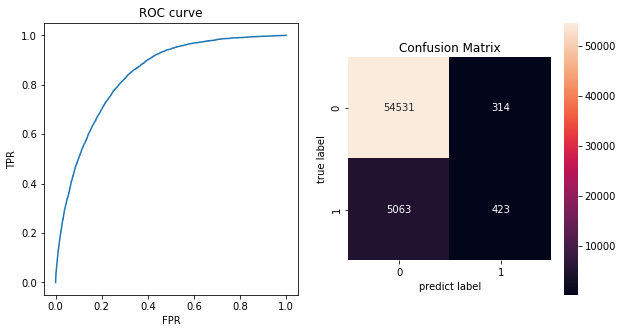

In [ ]:
import xgboost as xgb
from sklearn import metrics

#불균형 처리 x
model = xgb.XGBClassifier() 
model.fit(x_train, y_train) 
y_pred = model.predict(x_test)


acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

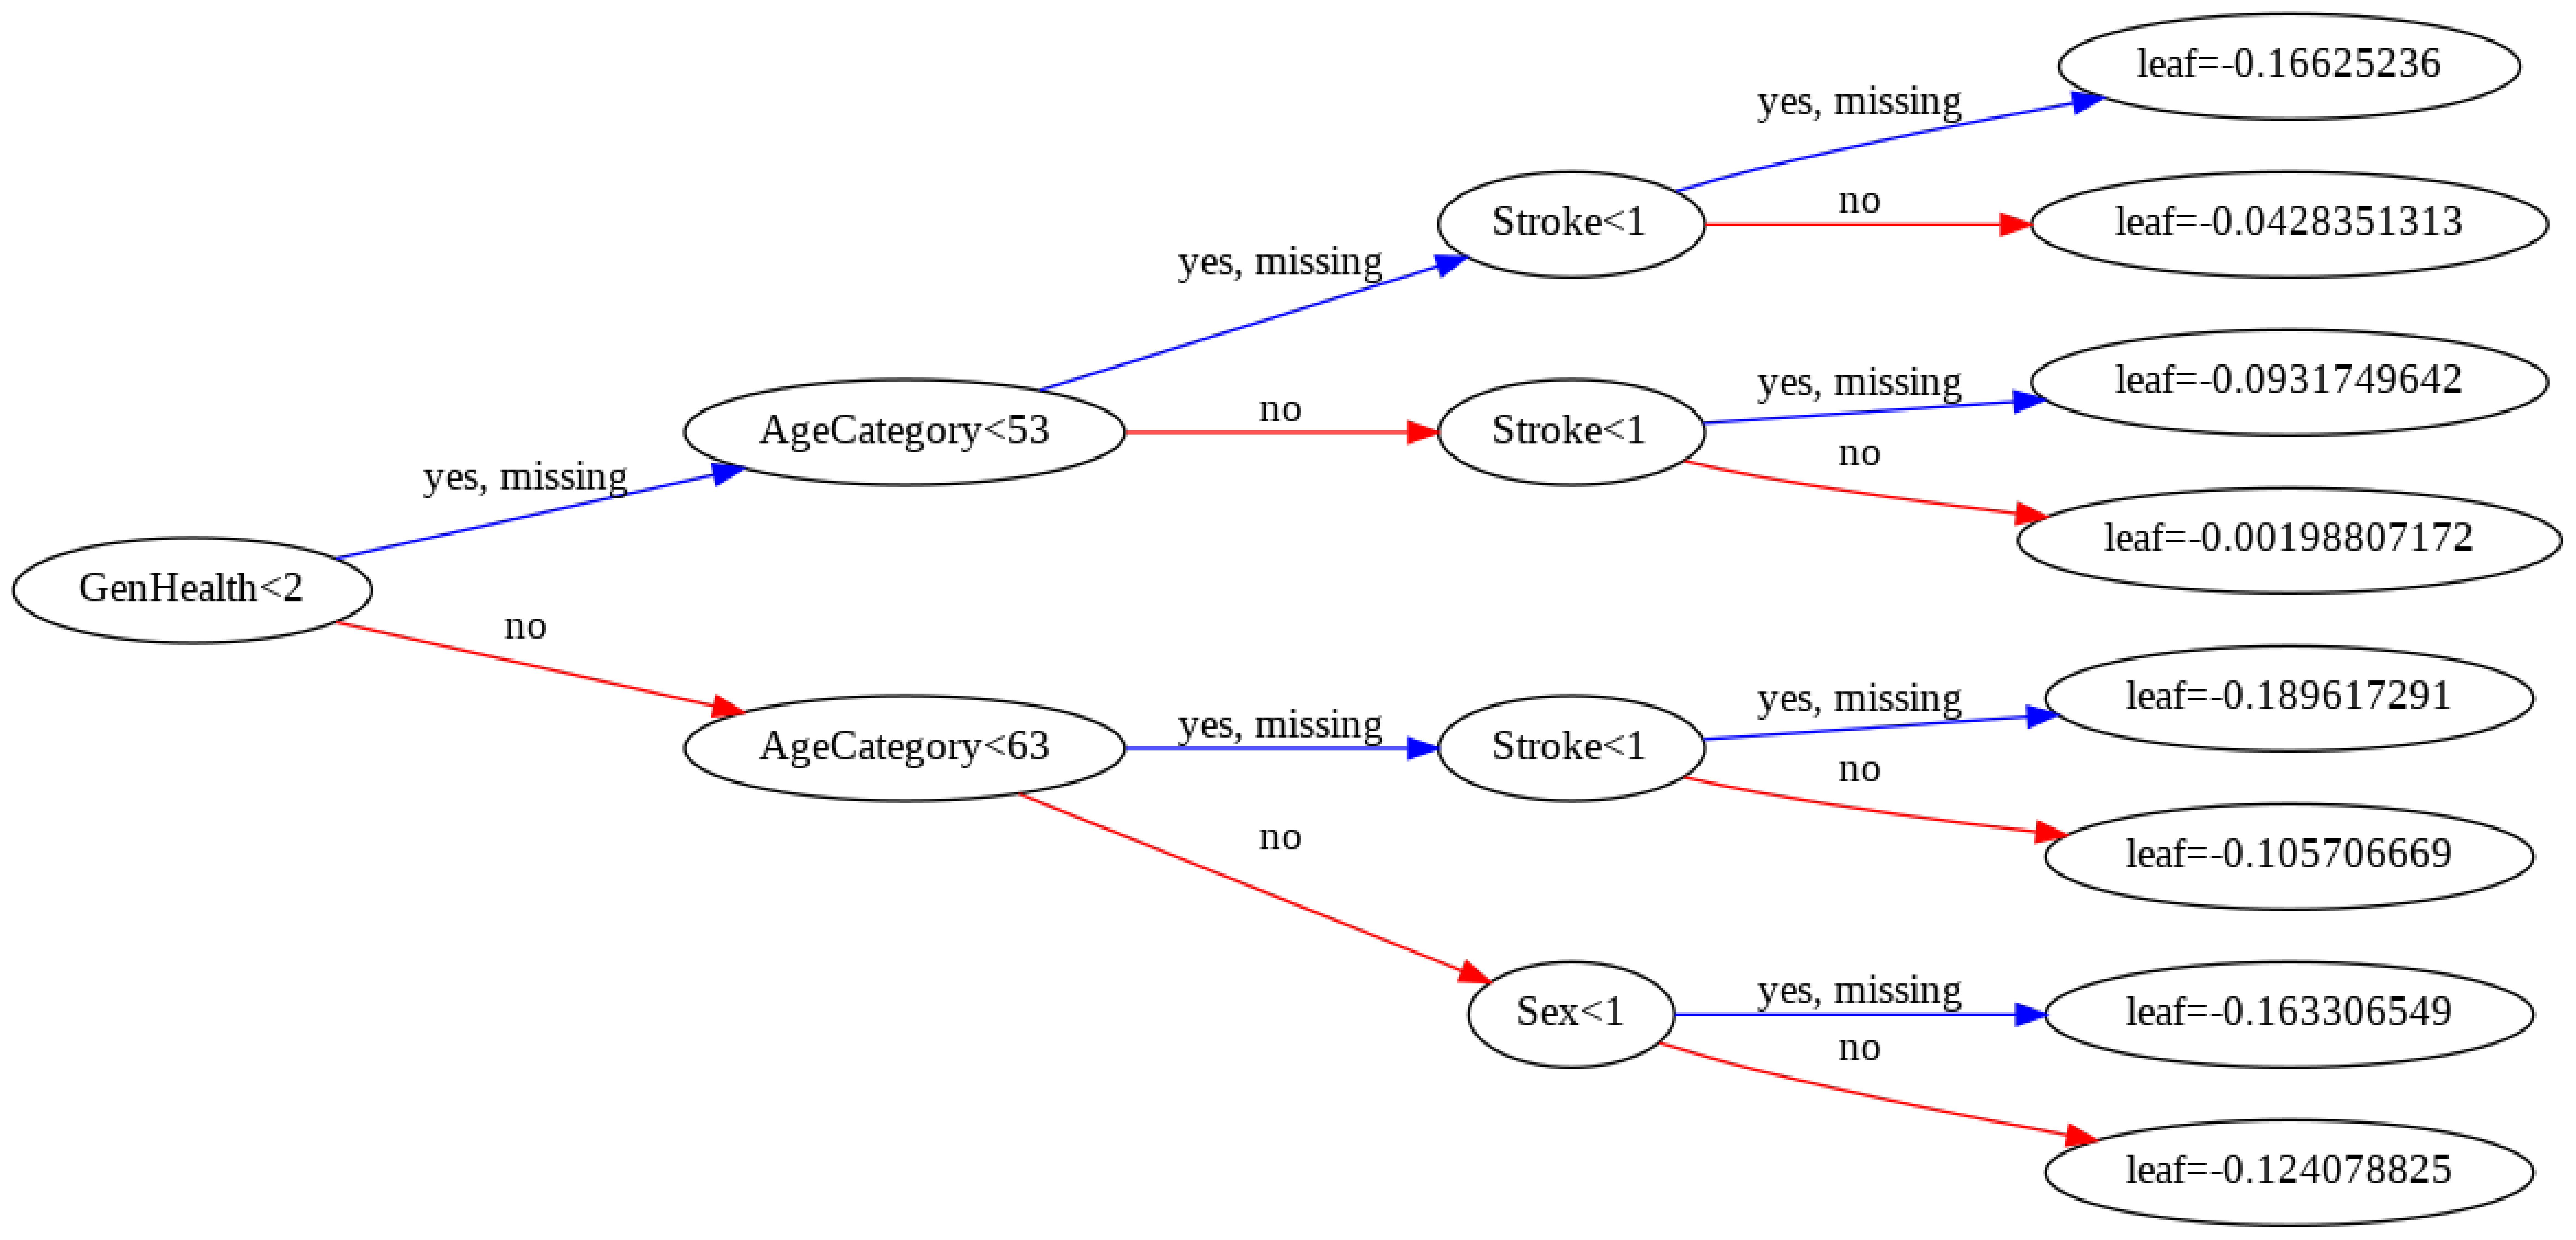

In [ ]:
# num_trees : 그림을 여러개 그릴시 그림 번호
# rankdir : 트리의 방향, 디폴트는 위아래 방향
# rankdir="LR" : 왼쪽에서 오른쪽 방향으로 트리를 보여준다.
xgb.plot_tree(model, num_trees=0, rankdir='LR')

fig = plt.gcf()
fig.set_size_inches(150, 100)

# 이미지 저장하고 싶다면
# fig.savefig('tree.png')

plt.show()

Accuracy 0.7818700170724835
Precision 0.24392685531233316
Recall 0.6662413415967918
F1 0.35710796287249635
AUC 0.8175344066948758
[[43516 11329]
 [ 1831  3655]]


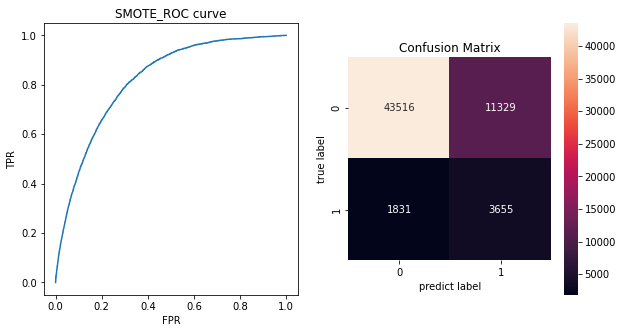

In [ ]:
#SMOTE
model = xgb.XGBClassifier()
model.fit(x_train_SMOTE, y_train_SMOTE)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('SMOTE_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

Accuracy 0.7823009729658053
Precision 0.24715683681565723
Recall 0.6813707619394823
F1 0.36273653566229985
AUC 0.8225825094796202
[[43459 11386]
 [ 1748  3738]]


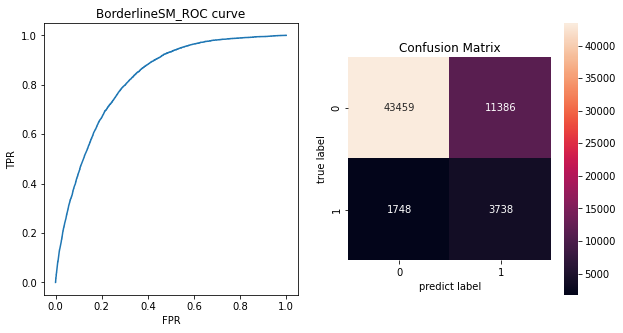

In [22]:
#BorderlineSMote
model = xgb.XGBClassifier()
model.fit(x_train_BorderlineSM, y_train_BorderlineSM)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('BorderlineSM_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

In [ ]:
#SVMSMote
model = xgb.XGBClassifier()
model.fit(x_train_SVMSMOTE, y_train_SVMSMOTE)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('SVMSMOTE_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

Accuracy 0.8139265054449619
Precision 0.2730866540164453
Recall 0.6296026248632883
F1 0.38094187713686994
AUC 0.8315373634250529
[[45651  9194]
 [ 2032  3454]]


Accuracy 0.773797881686032
Precision 0.23590706103164844
Recall 0.6644185198687569
F1 0.34818741940106035
AUC 0.8131355368742593
[[43039 11806]
 [ 1841  3645]]


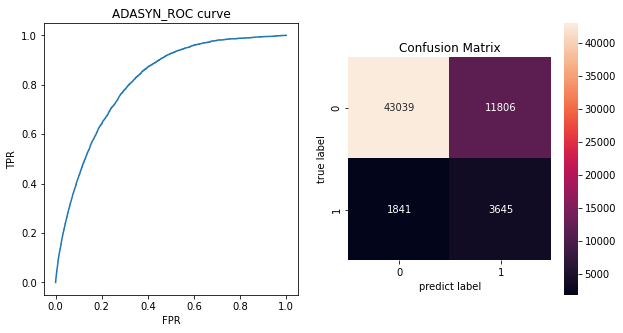

In [ ]:
#ADASYN
model = xgb.XGBClassifier()
model.fit(x_train_ADASYN, y_train_ADASYN)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('ADASYN_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

Accuracy 0.7515042018199599
Precision 0.2325267304445695
Recall 0.7531899380240612
F1 0.35534915720674237
AUC 0.830036653855676
[[41207 13638]
 [ 1354  4132]]


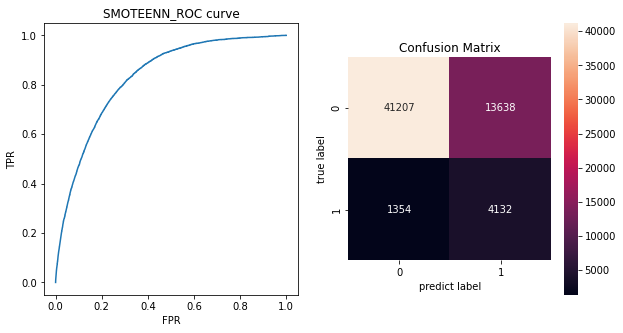

In [ ]:
#SMOTEENN
model = xgb.XGBClassifier()
model.fit(x_train_SMOTEENN, y_train_SMOTEENN)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('SMOTEENN_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

In [ ]:
#Costsensitive
model = xgb.XGBClassifier(scale_pos_weight=10) #no와 yes의 개수가 거의 10배
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)

y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('CostSenstive_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()


Accuracy 0.7311498234738361
Precision 0.22505122950819673
Recall 0.8007655851257747
F1 0.35135567463808687
AUC 0.8403246553680414
[[39718 15127]
 [ 1093  4393]]


# **PDP**

In [23]:
!pip install pdpbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 564 kB 11.6 MB/s 


In [28]:
from pdpbox import pdp
import shap

#분포를 보기위해 yes no와 그 외로 피쳐 분리
feature = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex',  'PhysicalActivity',   'Asthma', 'KidneyDisease',
       'SkinCancer', 'Diabetic']
feature2=['BMI', 'PhysicalHealth', 'MentalHealth', 'AgeCategory',  'GenHealth', 'SleepTime']
features = x_test.columns

print(x_test.columns)

Index([                              'BMI',
                                 'Smoking',
                         'AlcoholDrinking',
                                  'Stroke',
                          'PhysicalHealth',
                            'MentalHealth',
                             'DiffWalking',
                                     'Sex',
                             'AgeCategory',
                                'Diabetic',
                        'PhysicalActivity',
                               'GenHealth',
                               'SleepTime',
                                  'Asthma',
                           'KidneyDisease',
                              'SkinCancer',
       ('American Indian/Alaskan Native',),
                                ('Asian',),
                                ('Black',),
                             ('Hispanic',),
                                ('Other',),
                                ('White',)],
      dtype='object')


## 불균형 처리x

In [29]:
import xgboost as xgb

model = xgb.XGBClassifier()
model.fit(x_train, y_train)

XGBClassifier()

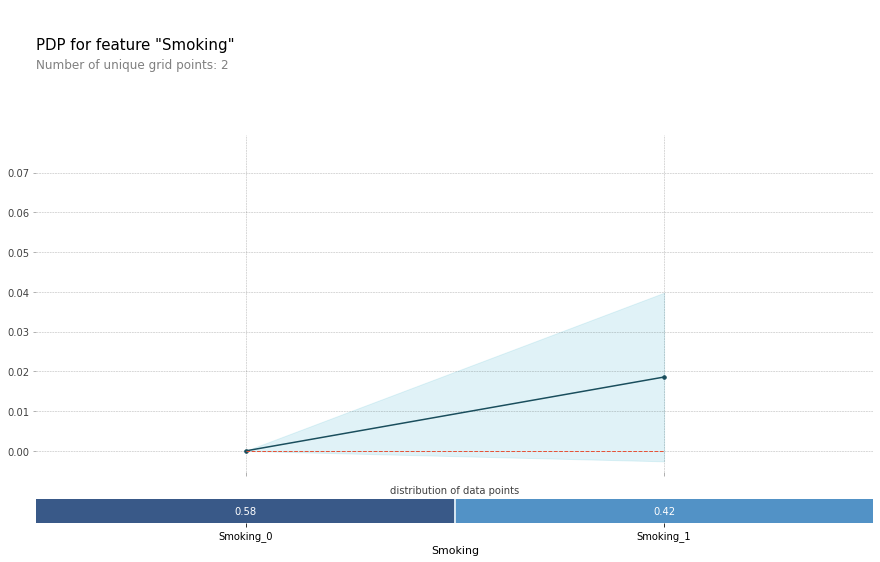

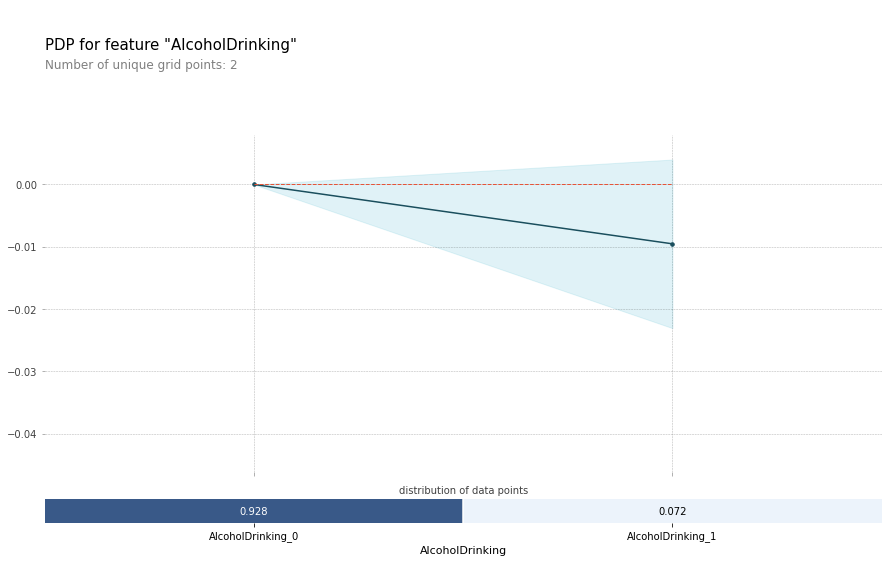

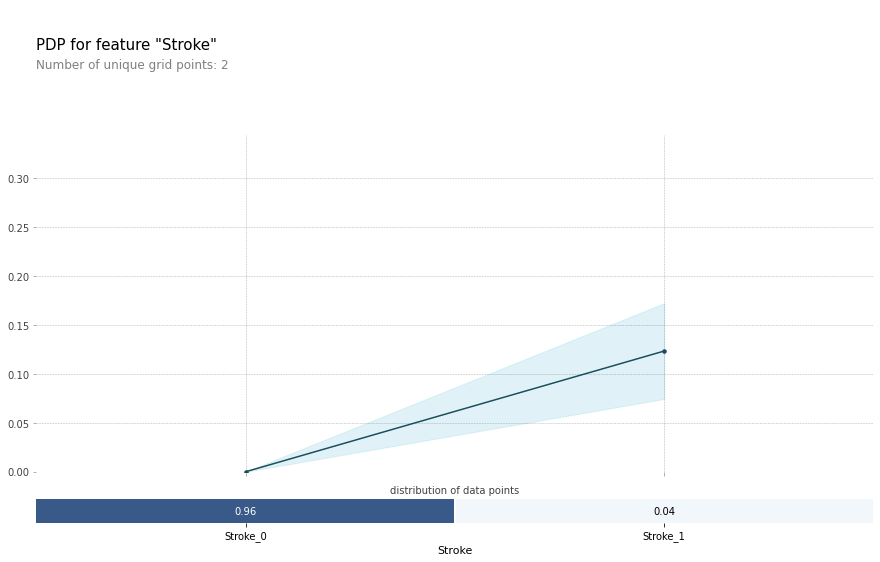

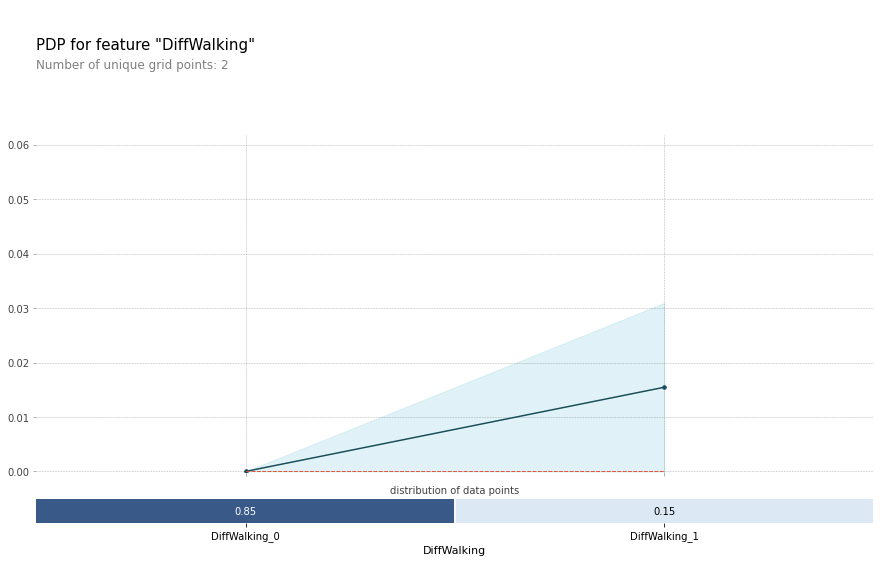

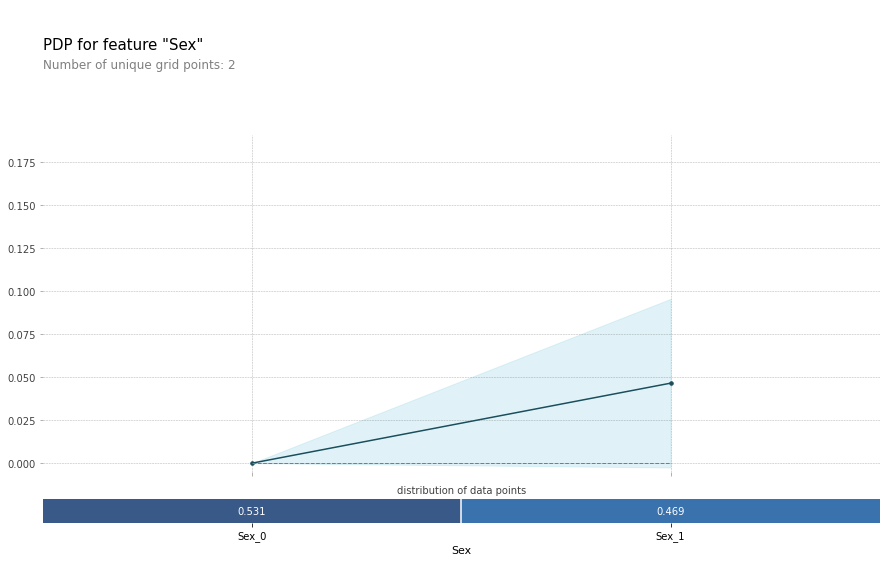

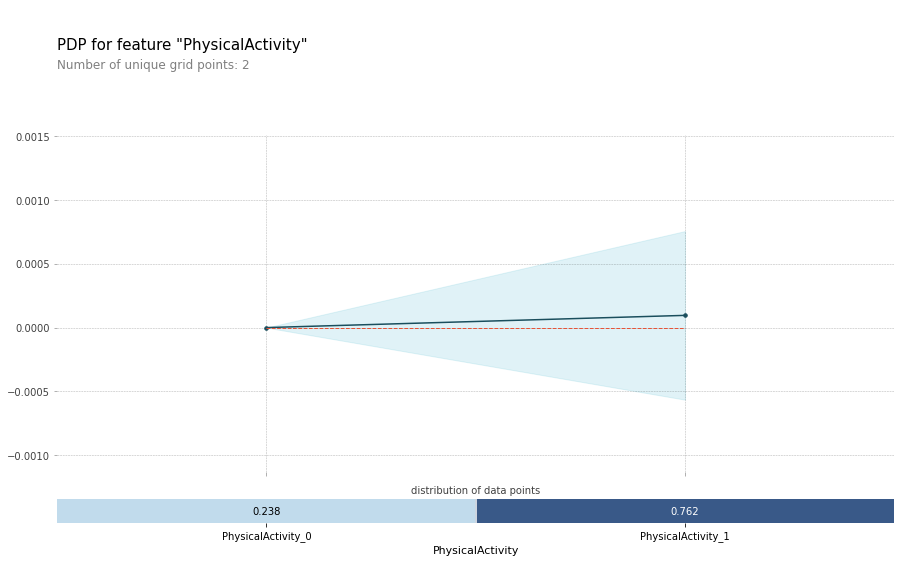

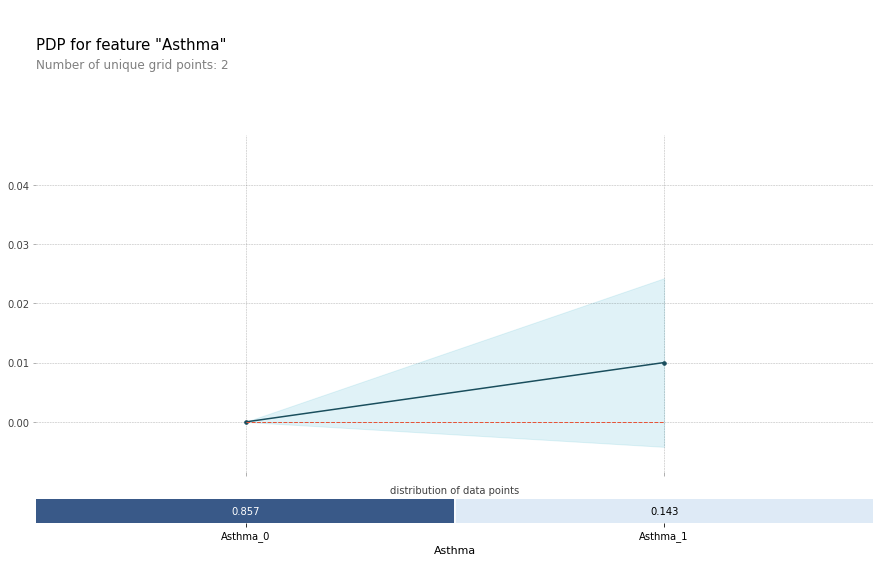

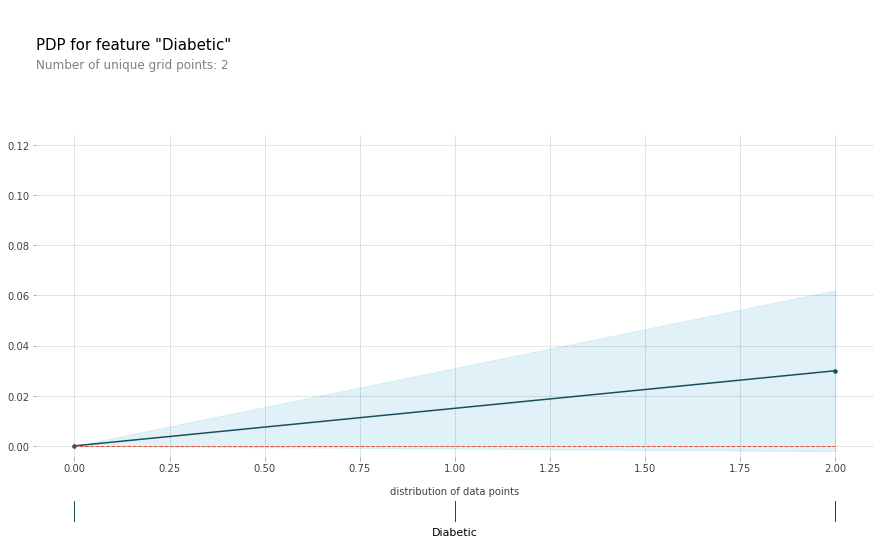

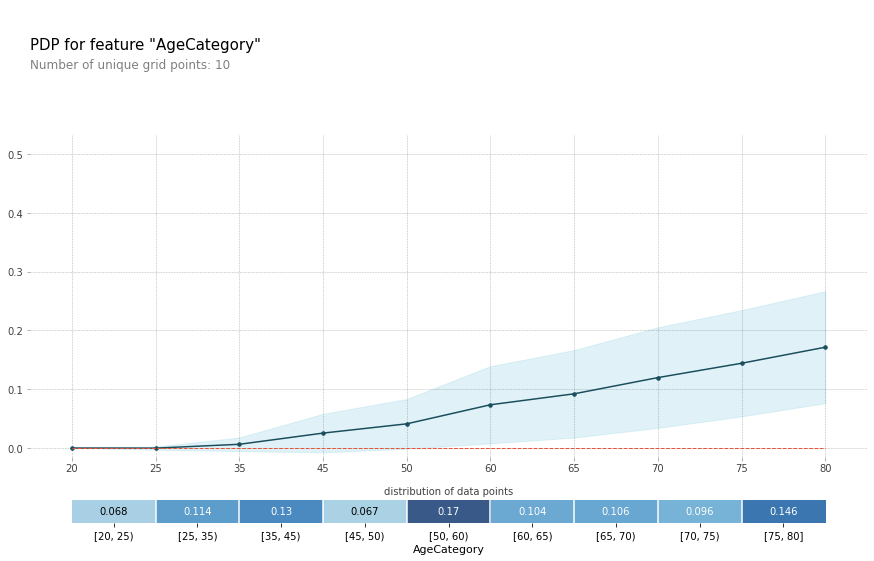

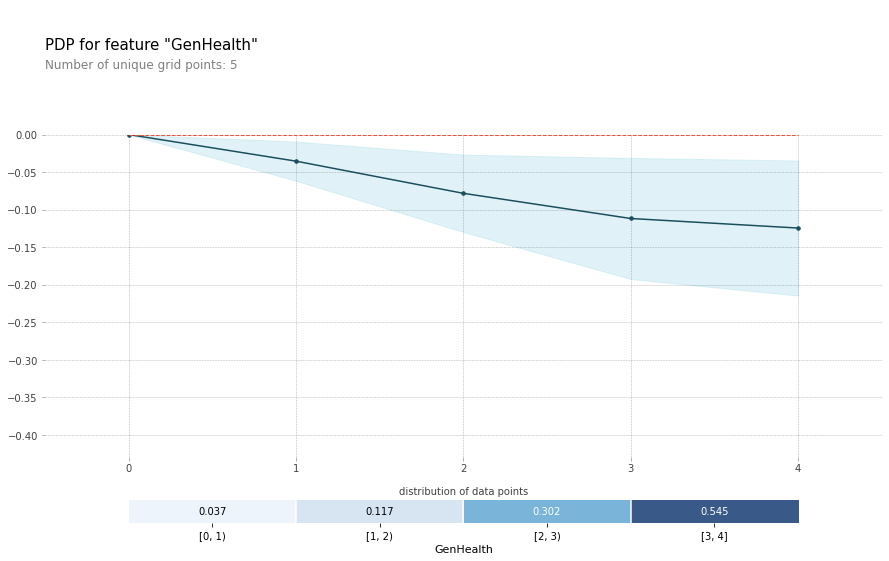

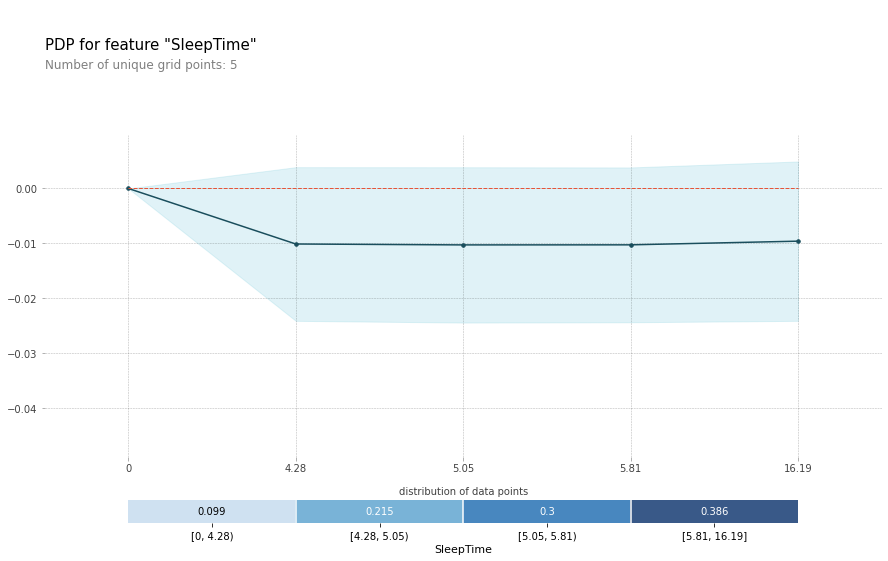

In [30]:
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i], plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], plot_pts_dist=True,  x_quantile=True)

#0.03303716681266425
#0.053253127652507656
#0.07572168114416074
#0.08132696195552289
#0.0983399209486166
#0.10445172480246676
#Asian, Hispanic, Other, Black, White

In [31]:
# ICE
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i],frac_to_plot=1000, plot_lines=True, plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], frac_to_plot=1000, plot_lines=True, plot_pts_dist=True,  x_quantile=True)

Output hidden; open in https://colab.research.google.com to view.

100%|===================| 60076/60331 [01:15<00:00]       

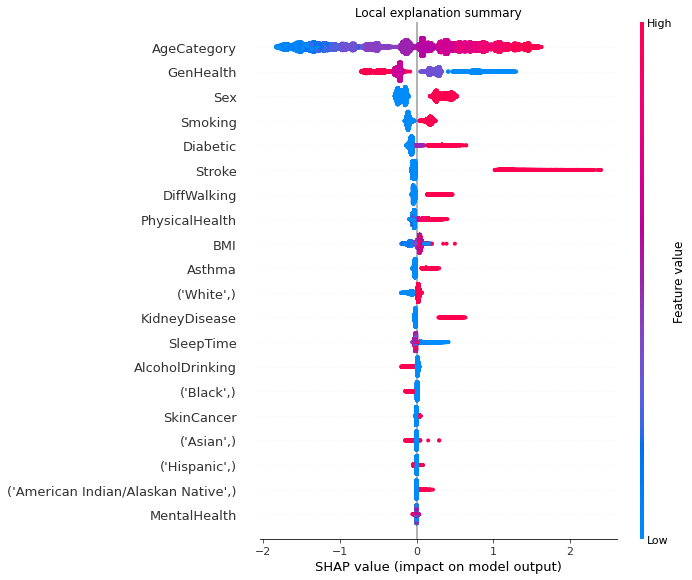

In [32]:
# SHAP
explainer = shap.Explainer(model, x_train, feature_names=features)
shap_values = explainer(x_test)

plt.title('Global feature importance')
shap.summary_plot(shap_values, plot_type="bar")


plt.title('Local explanation summary')
shap.summary_plot(shap_values)

## Costsensitive

In [33]:
import xgboost as xgb

model_cost = xgb.XGBClassifier(scale_pos_weight=10)
model_cost.fit(x_train, y_train)

XGBClassifier(scale_pos_weight=10)

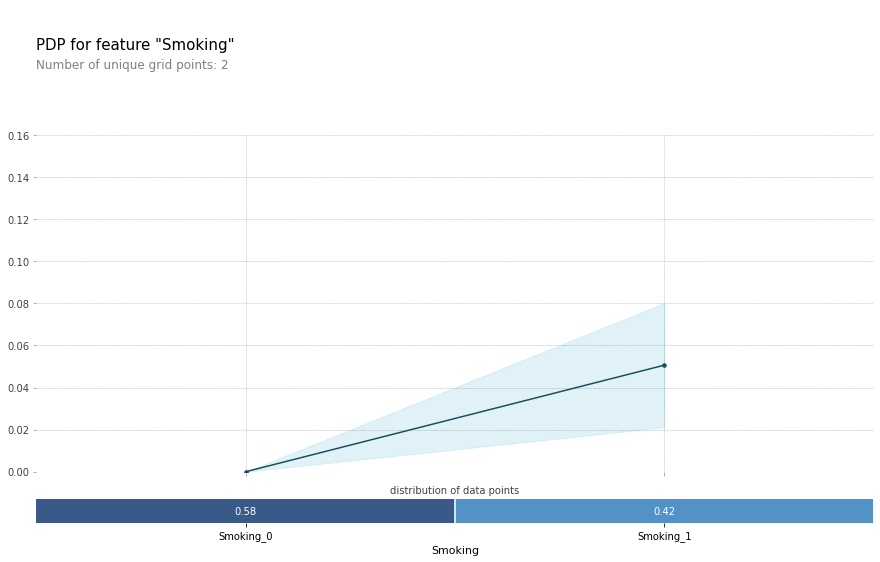

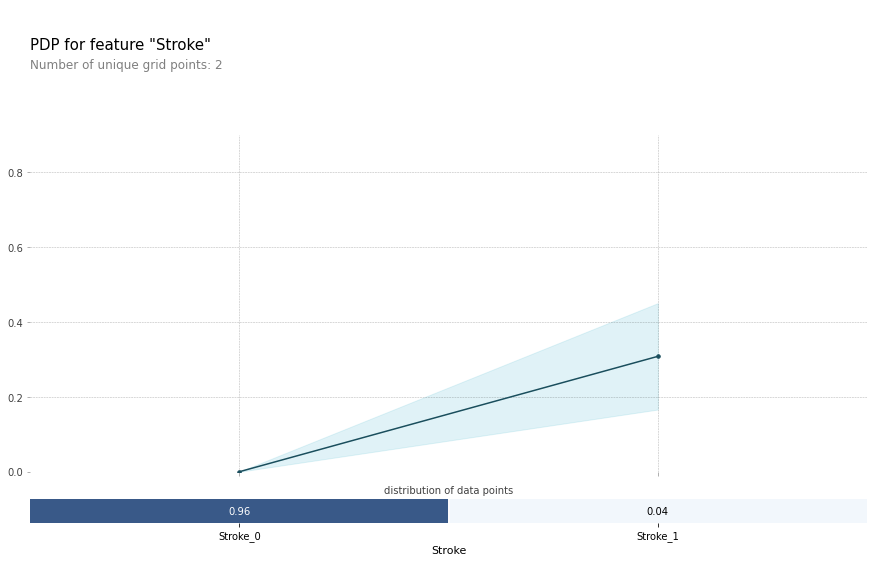

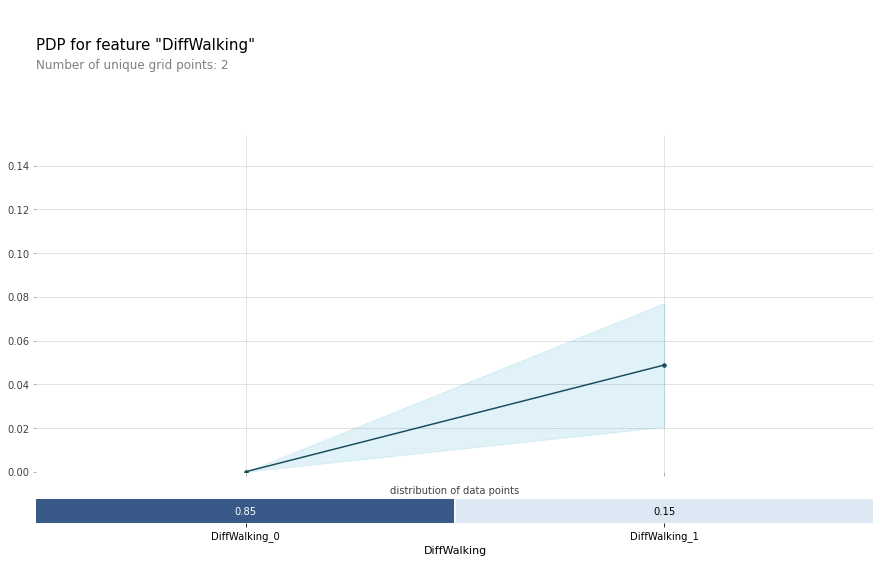

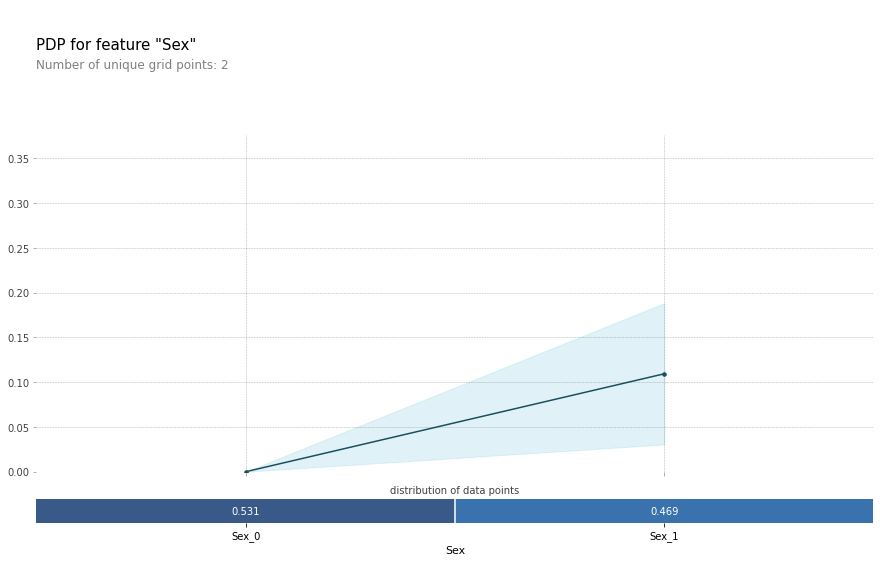

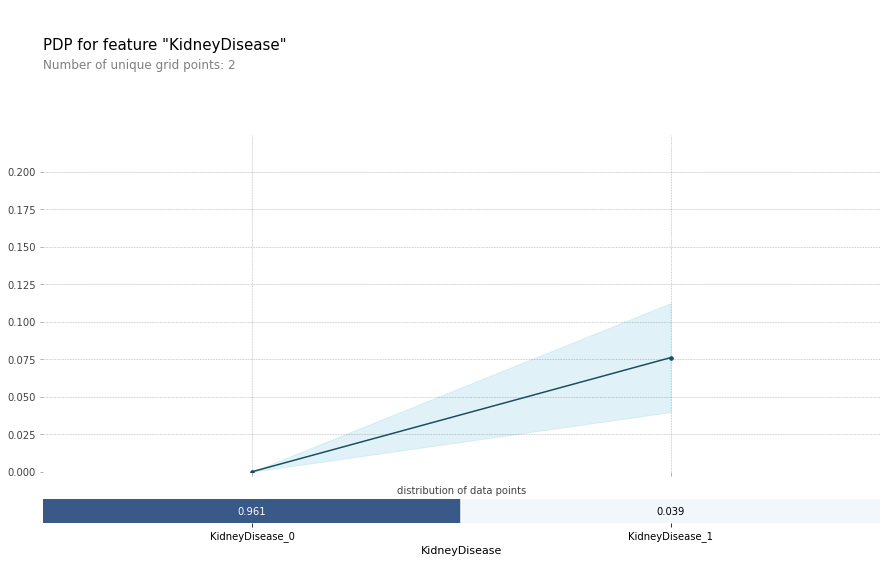

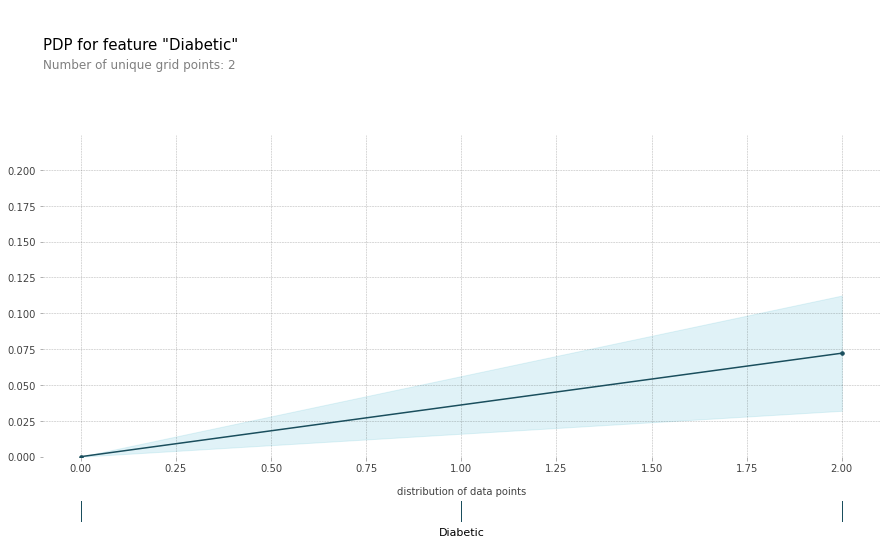

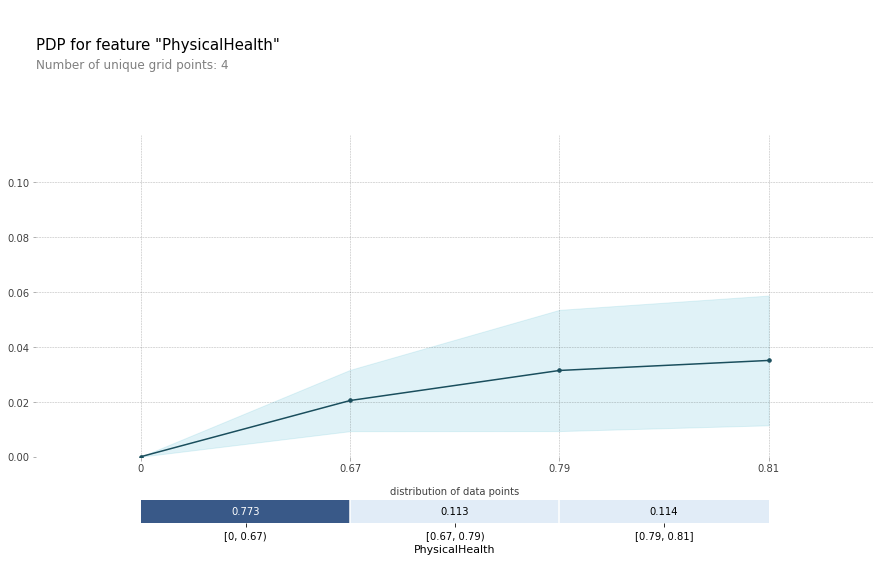

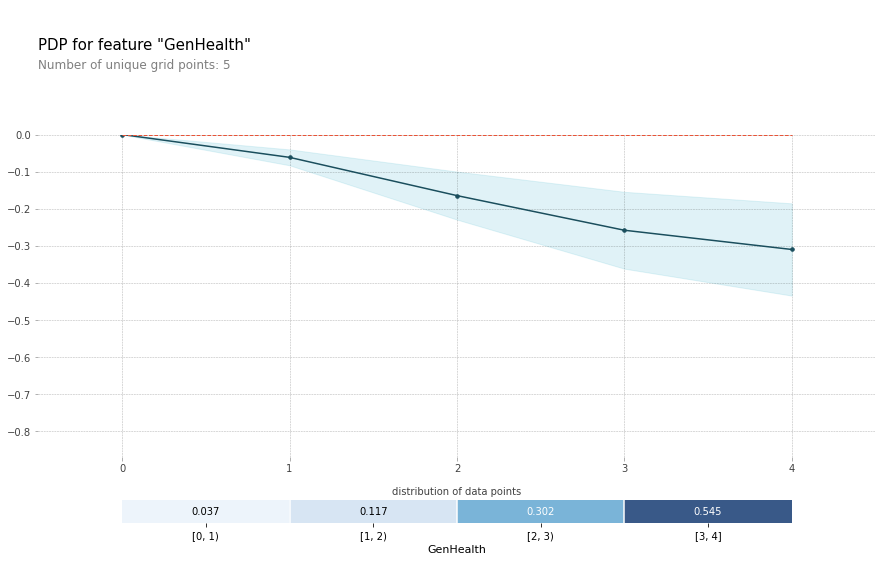

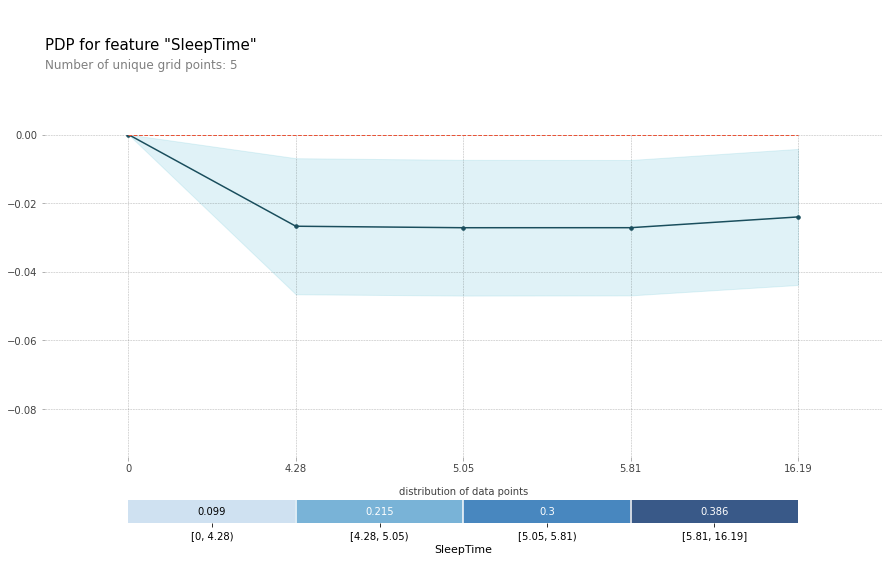

In [34]:
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_cost, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i], plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_cost, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], plot_pts_dist=True,  x_quantile=True)

In [35]:
# ICE
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_cost, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i],frac_to_plot=1000, plot_lines=True, plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_cost, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], frac_to_plot=1000, plot_lines=True, plot_pts_dist=True,  x_quantile=True)

Output hidden; open in https://colab.research.google.com to view.

 99%|===================| 59690/60331 [01:10<00:00]       

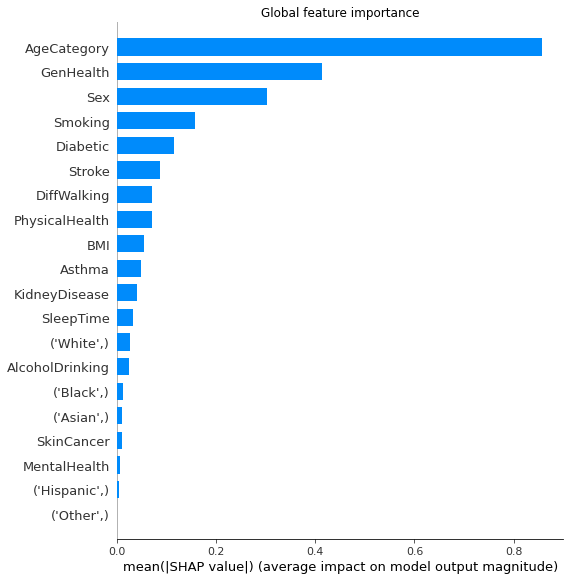

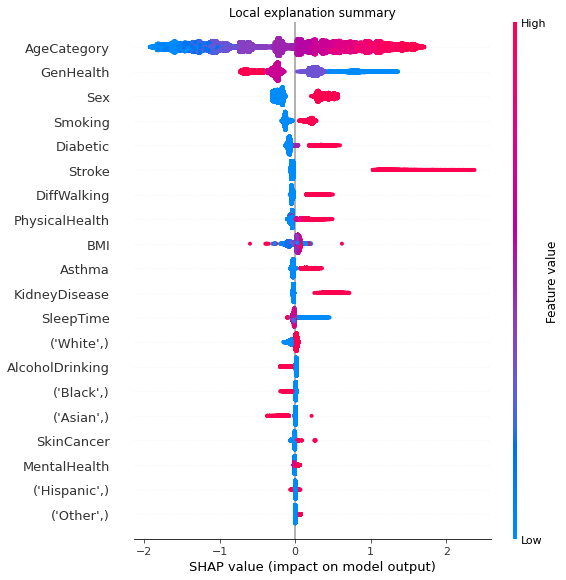

In [36]:
# SHAP
explainer = shap.Explainer(model_cost, x_train, feature_names=features)
shap_values = explainer(x_test)

plt.title('Global feature importance')
shap.summary_plot(shap_values, plot_type="bar")


plt.title('Local explanation summary')
shap.summary_plot(shap_values)

## SMOTE

In [37]:
import xgboost as xgb

model_SMOTE = xgb.XGBClassifier()
model_SMOTE.fit(x_train_SMOTE, y_train_SMOTE)

XGBClassifier()

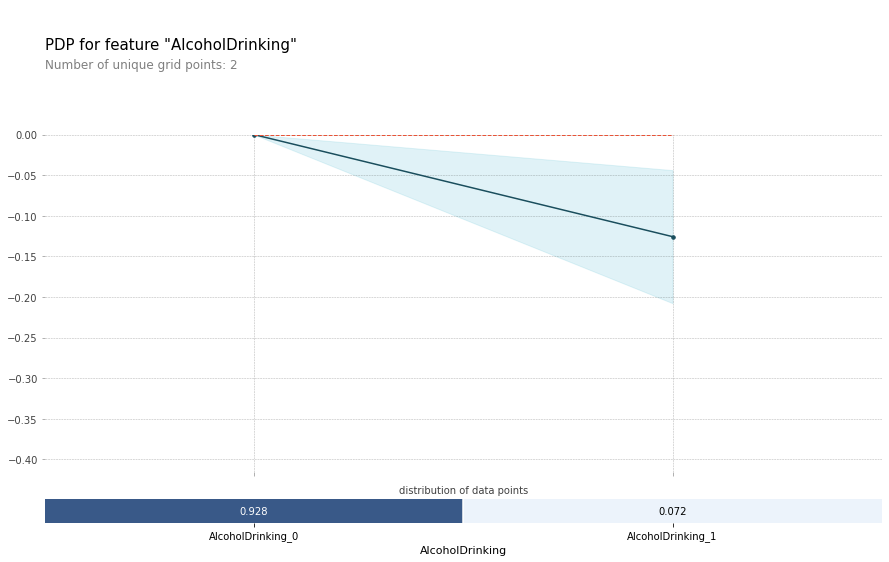

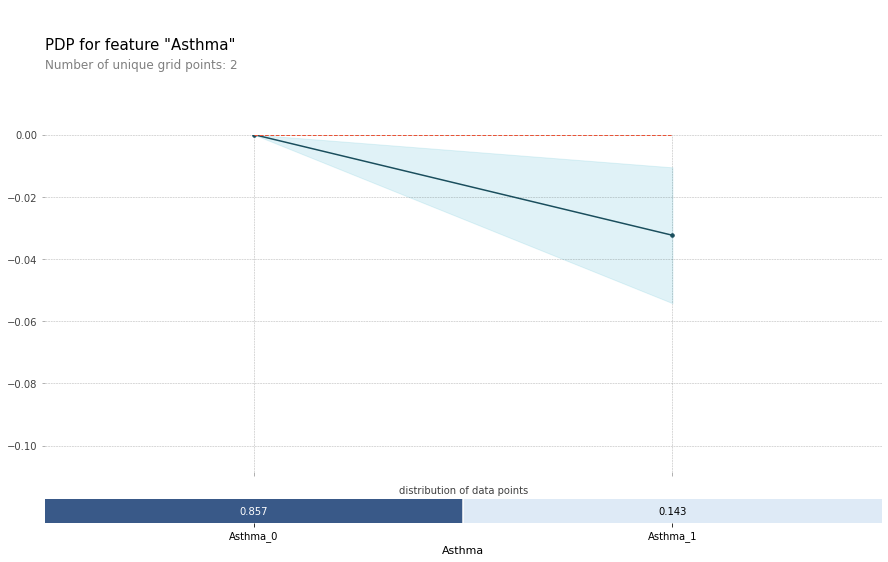

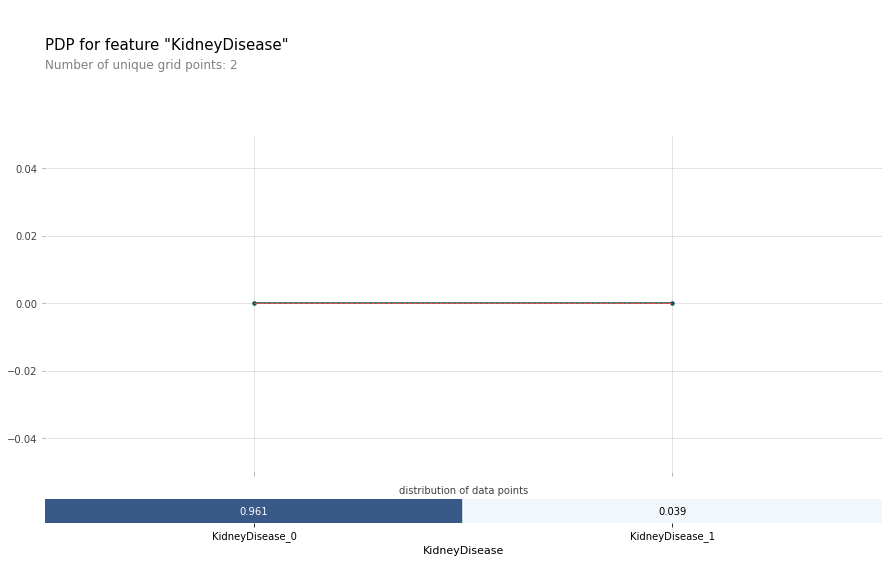

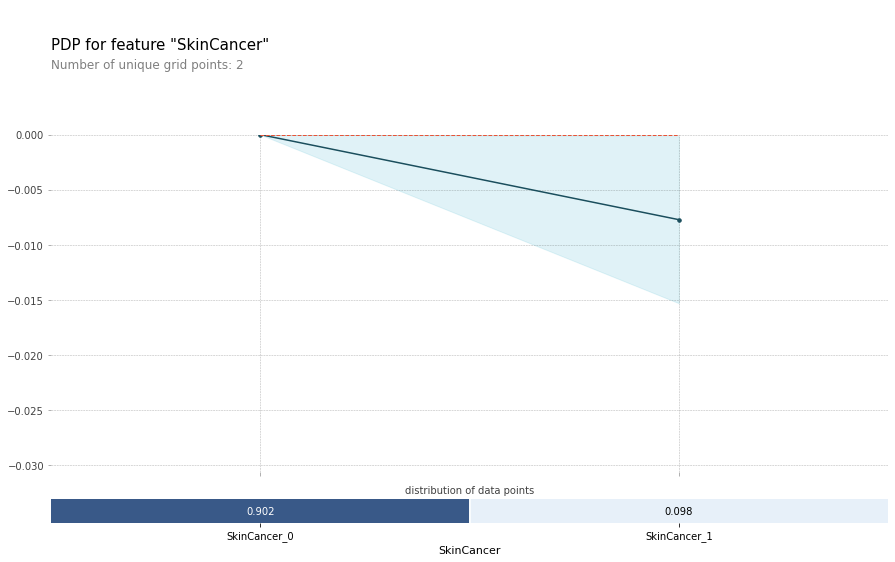

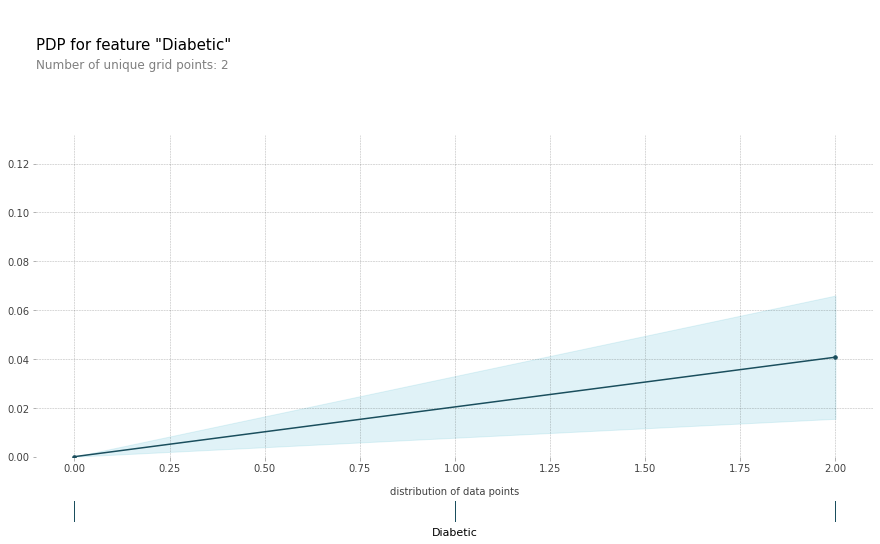

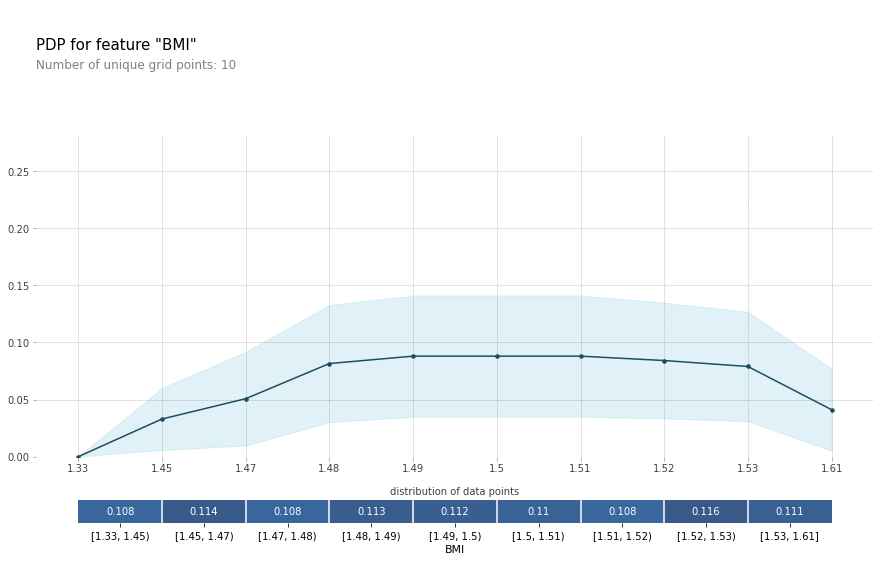

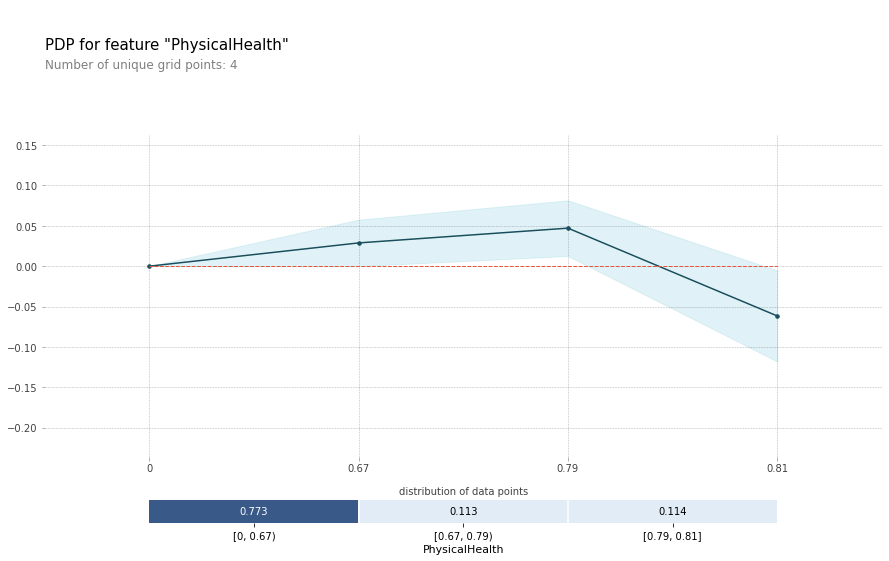

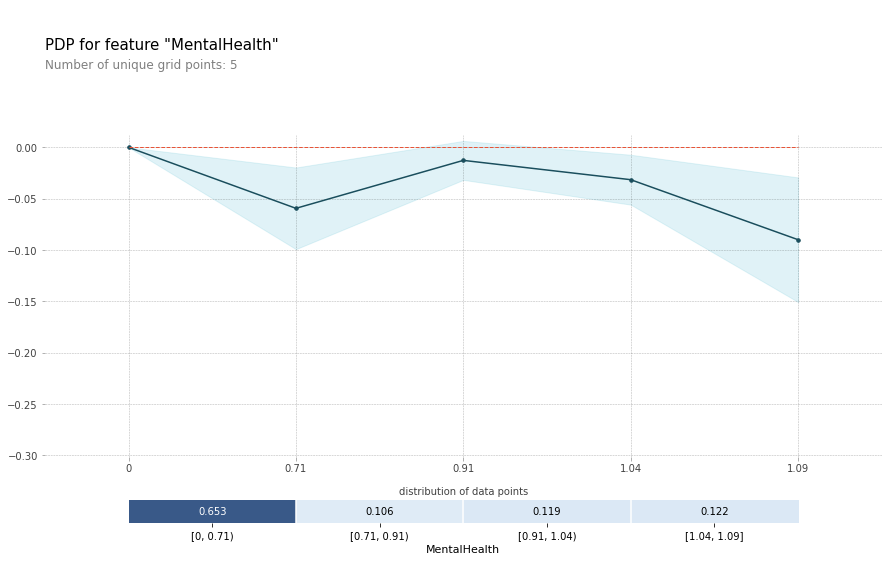

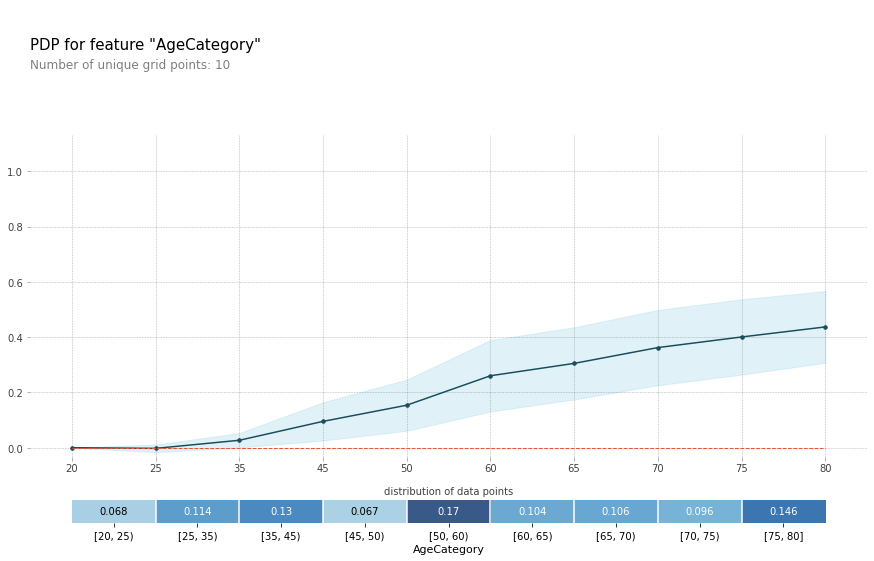

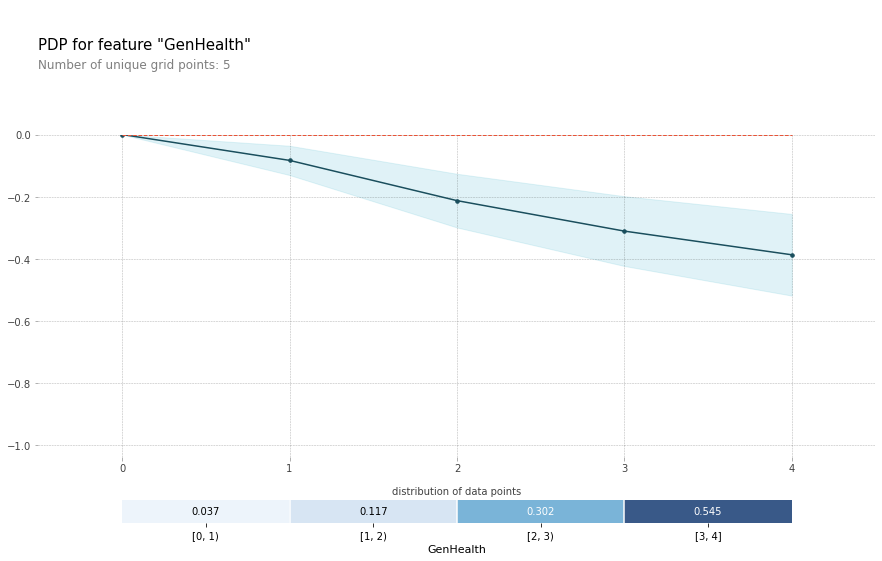

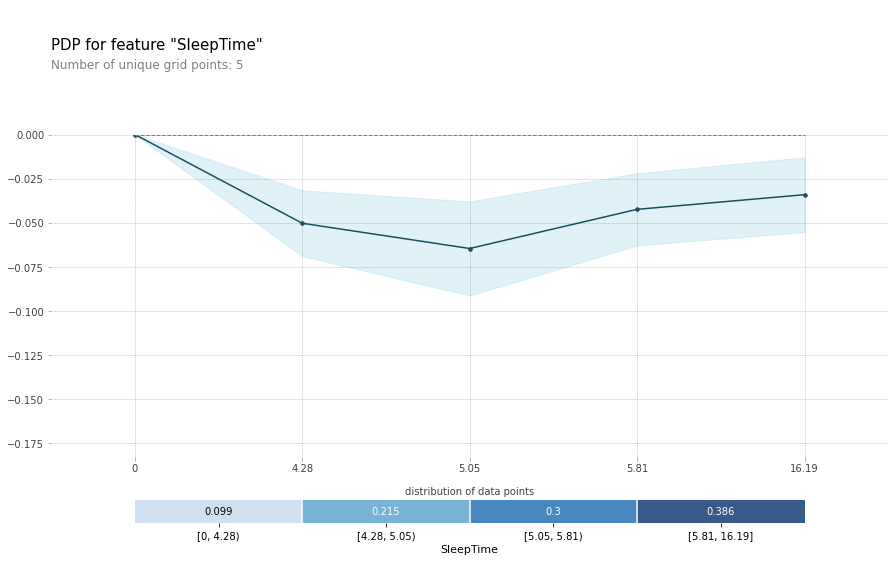

In [38]:
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_SMOTE, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i], plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_SMOTE, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], plot_pts_dist=True,  x_quantile=True)

In [39]:
# ICE
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_SMOTE, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i],frac_to_plot=1000, plot_lines=True, plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_SMOTE, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], frac_to_plot=1000, plot_lines=True, plot_pts_dist=True,  x_quantile=True)

Output hidden; open in https://colab.research.google.com to view.

100%|===================| 60284/60331 [01:09<00:00]       

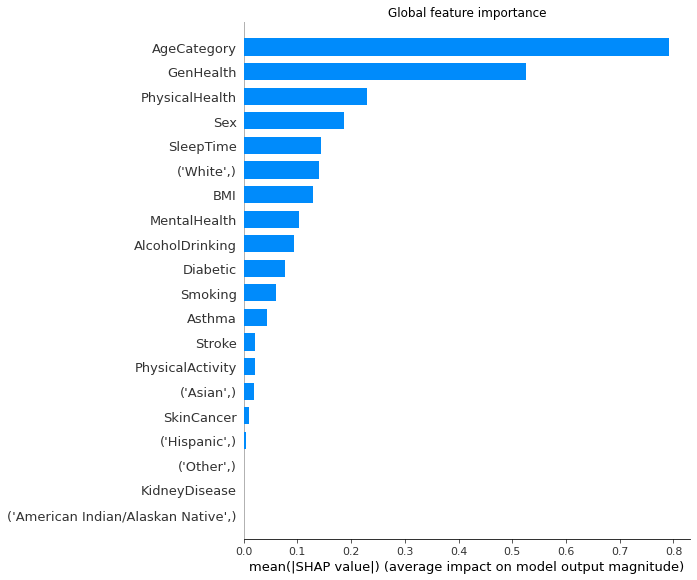

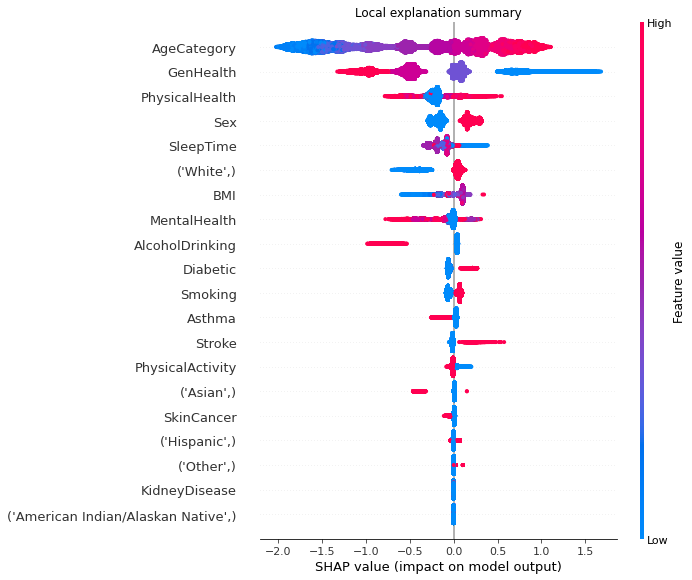

In [40]:
# SHAP
explainer = shap.Explainer(model_SMOTE, x_train_SMOTE, feature_names=features)
shap_values = explainer(x_test, check_additivity=False)

plt.title('Global feature importance')
shap.summary_plot(shap_values, plot_type="bar")


plt.title('Local explanation summary')
shap.summary_plot(shap_values)

## BorderlineSMOTE

In [41]:
model_BorderlineSM = xgb.XGBClassifier()
model_BorderlineSM.fit(x_train_BorderlineSM, y_train_BorderlineSM)

XGBClassifier()

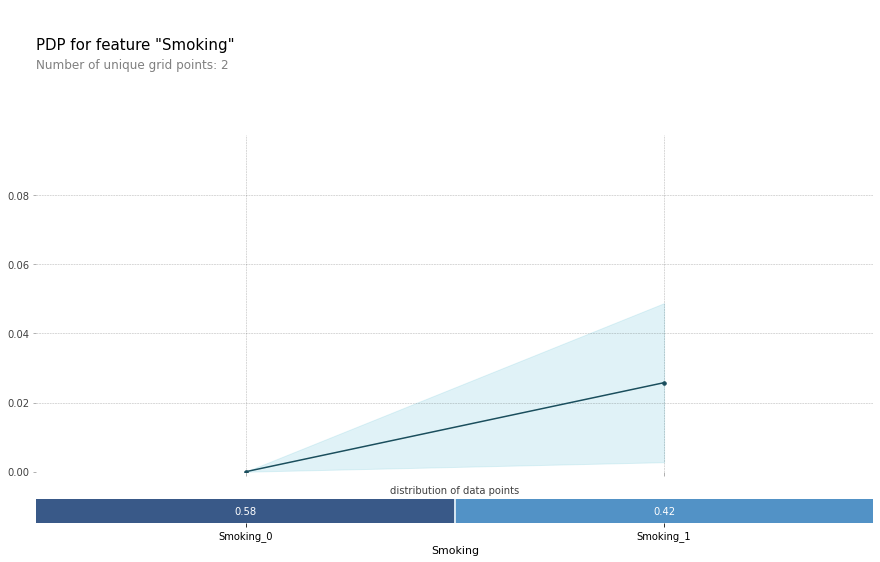

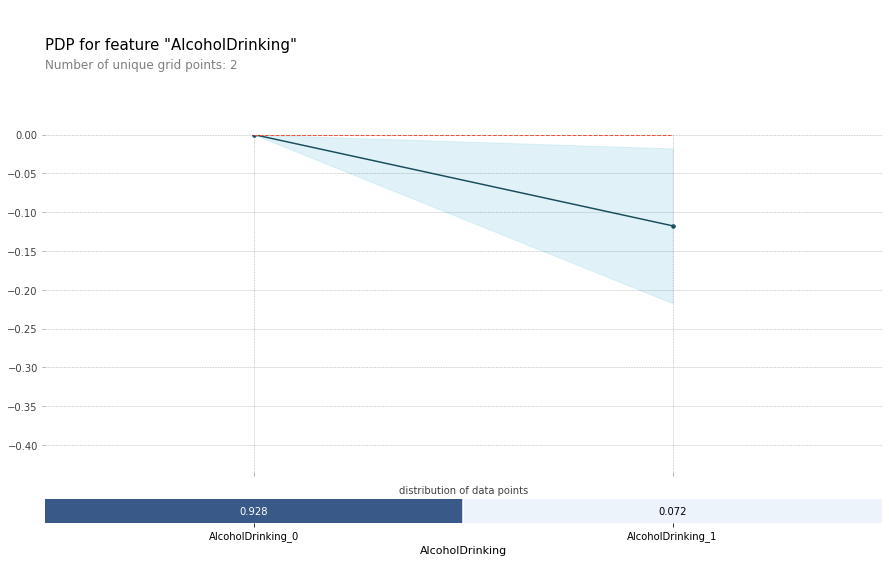

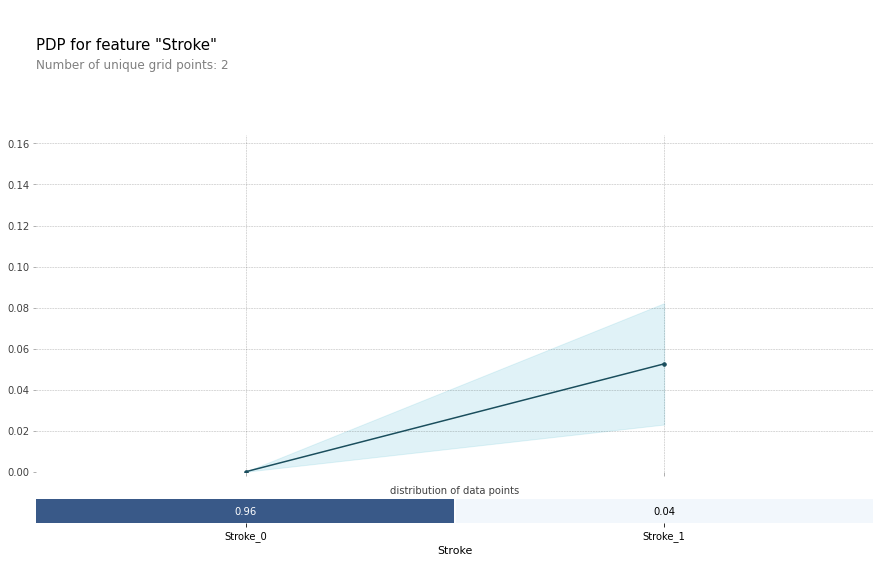

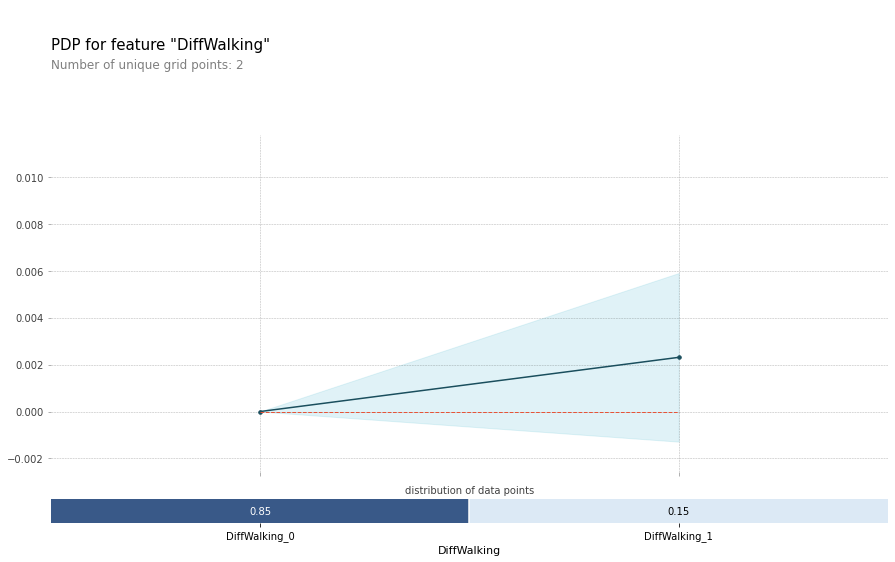

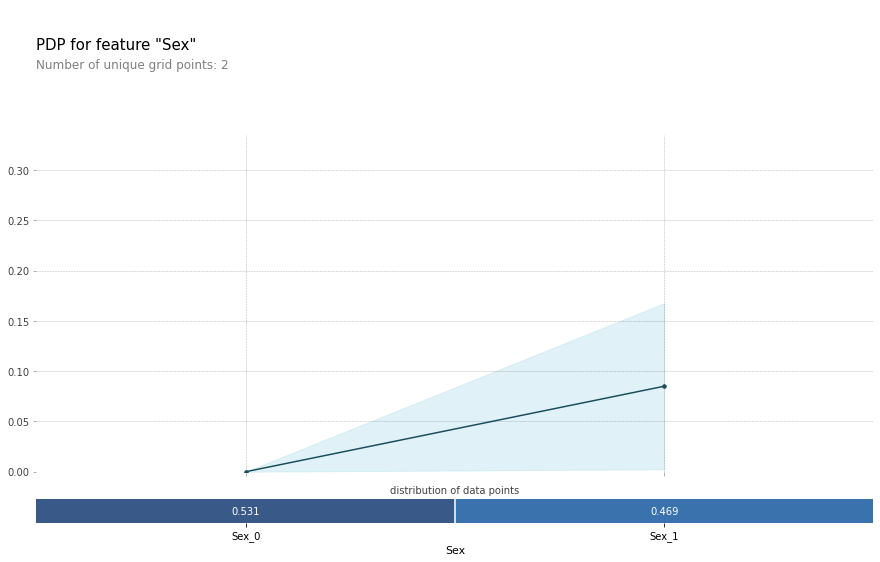

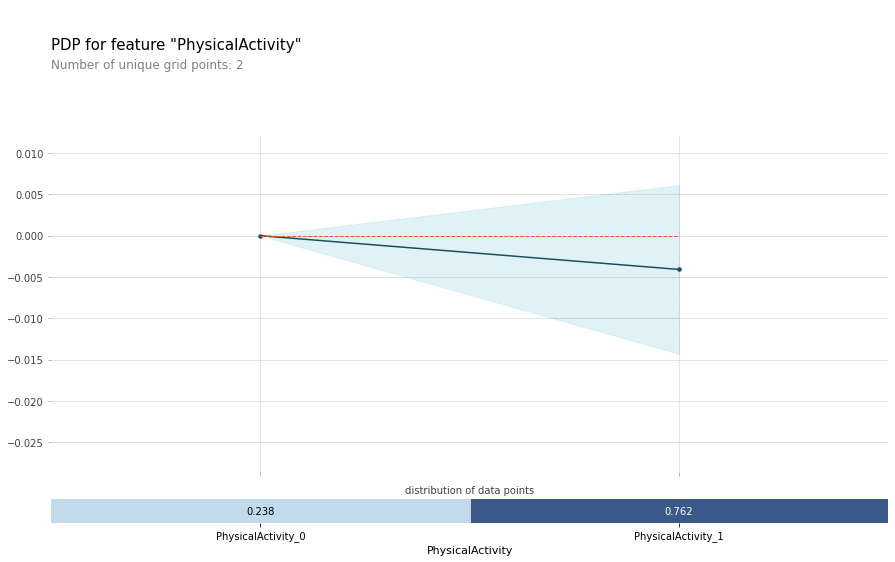

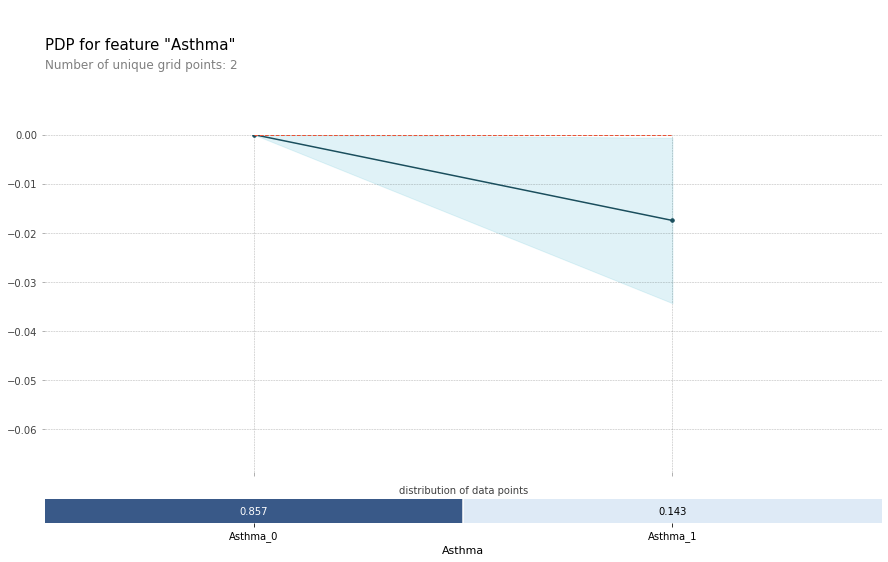

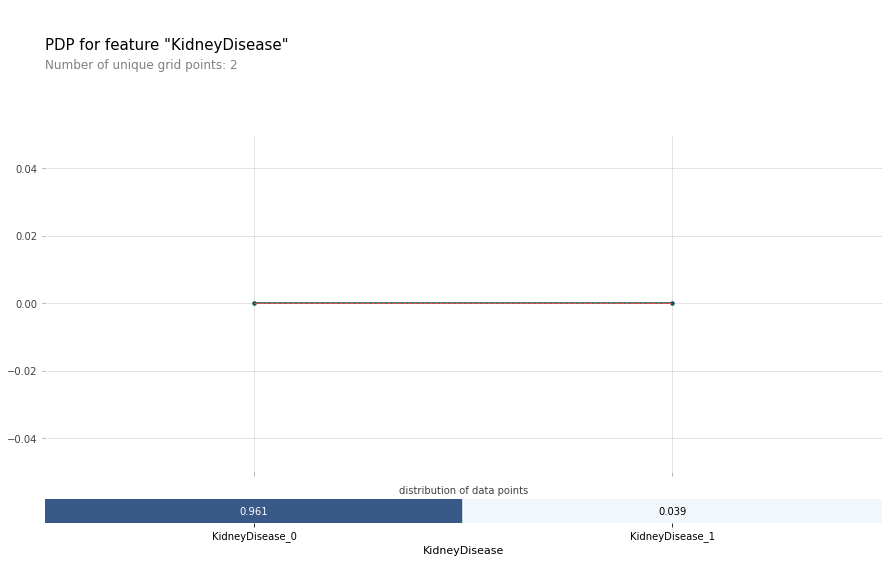

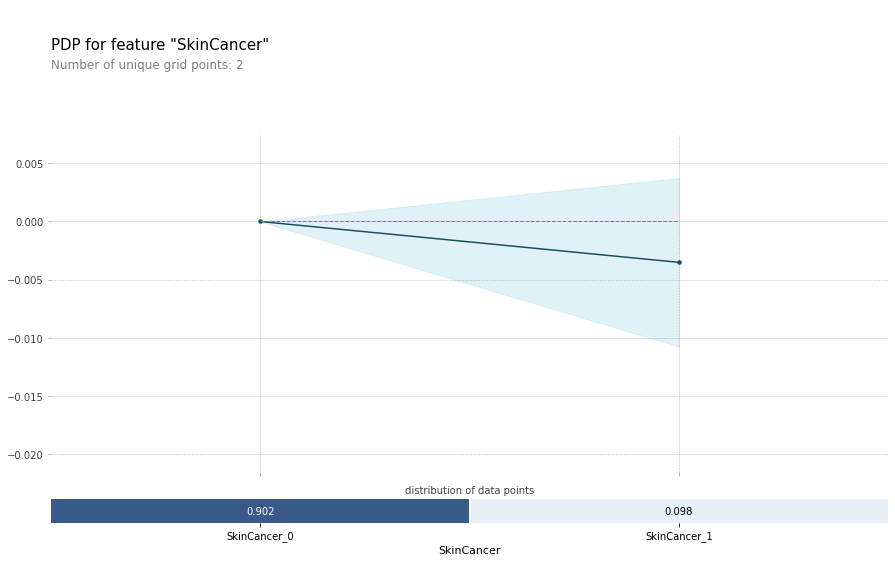

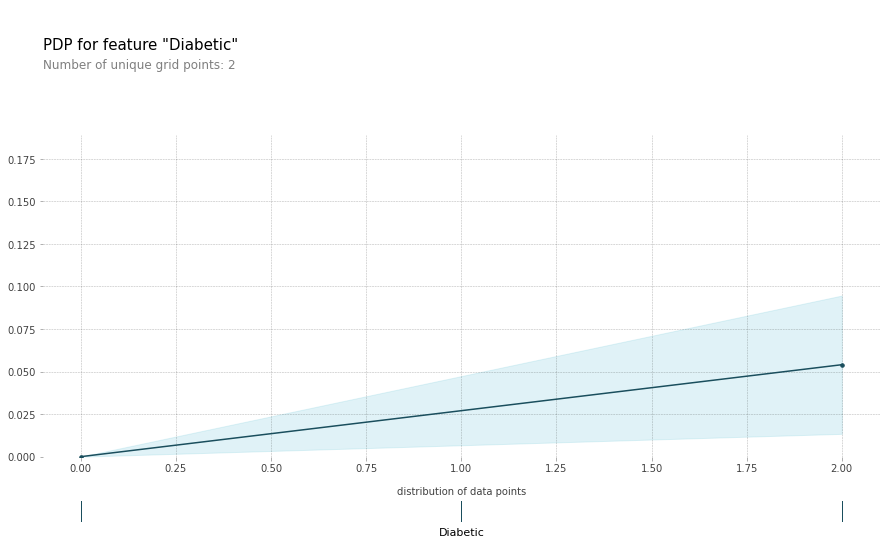

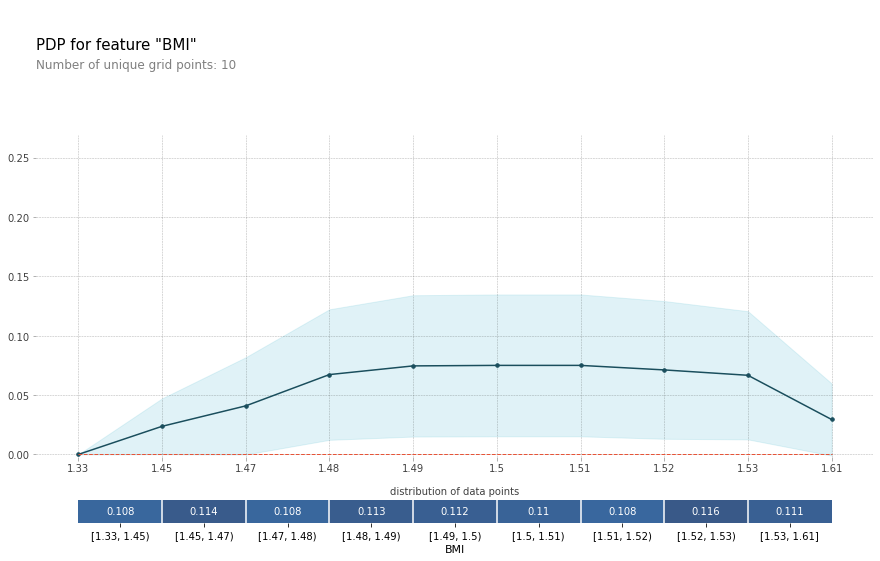

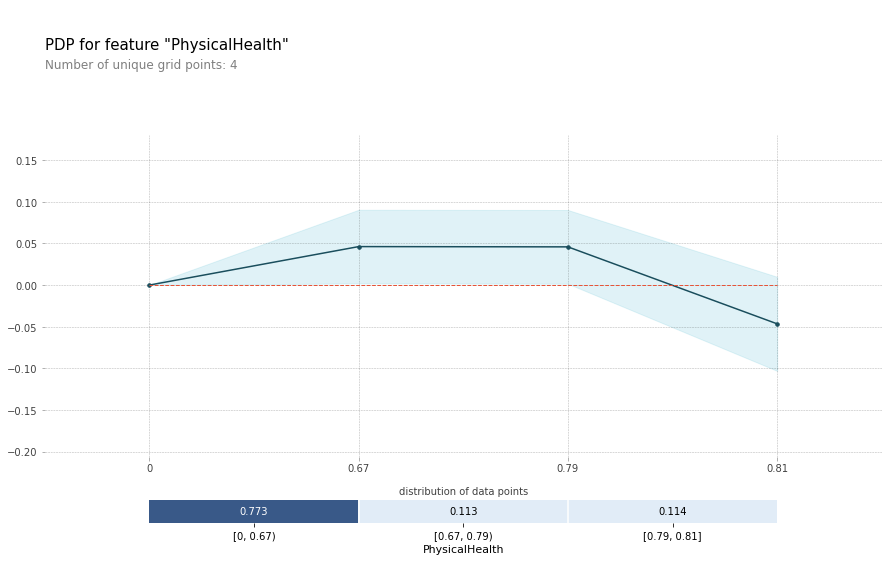

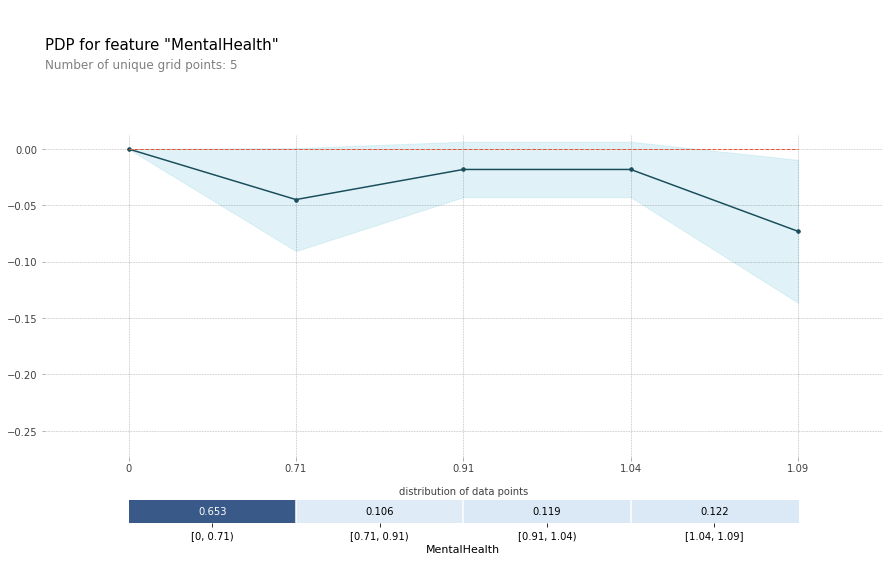

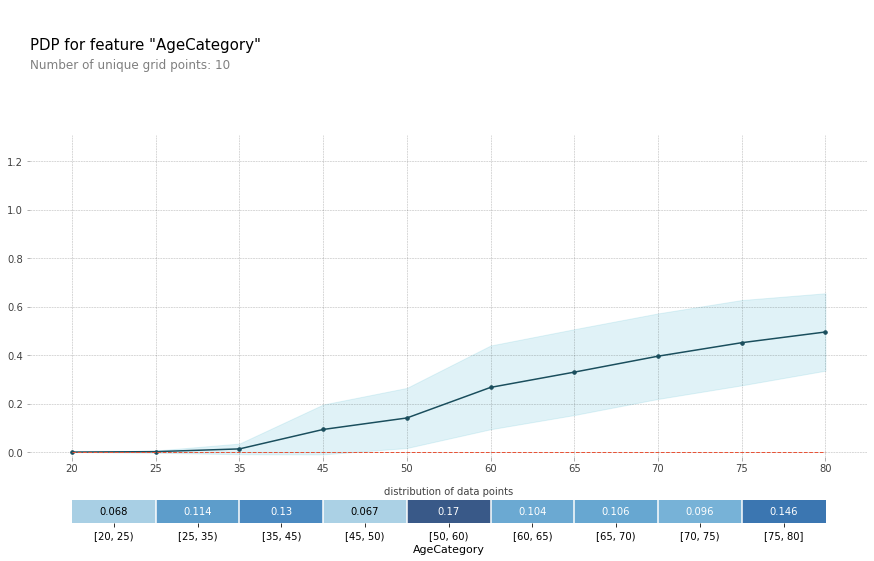

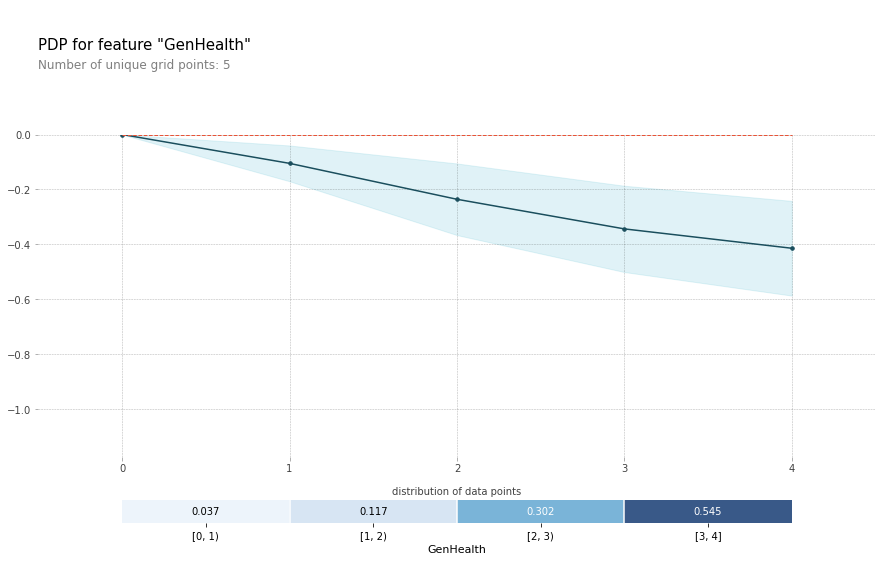

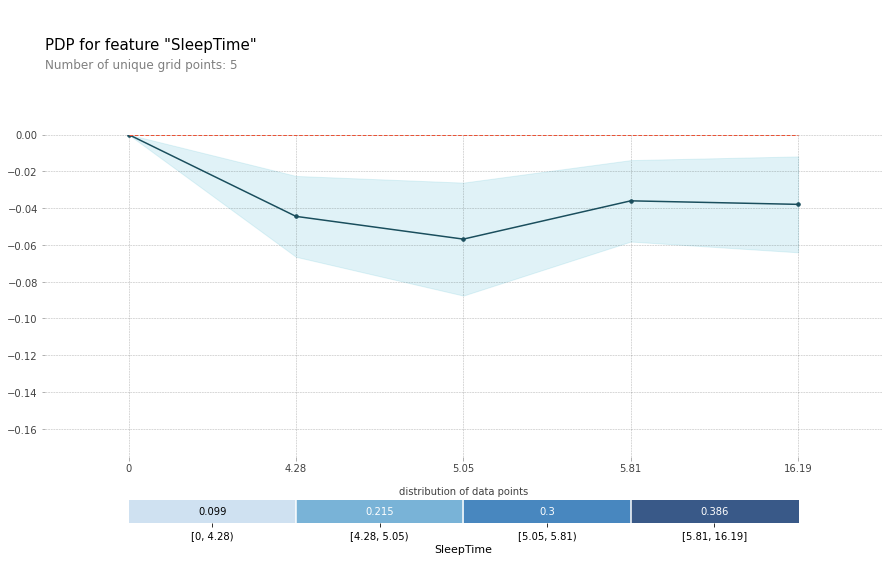

In [42]:
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_BorderlineSM, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i], plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_BorderlineSM, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], plot_pts_dist=True,  x_quantile=True)

In [43]:
# ICE
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_BorderlineSM, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i],frac_to_plot=1000, plot_lines=True, plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_BorderlineSM, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], frac_to_plot=1000, plot_lines=True, plot_pts_dist=True,  x_quantile=True)

Output hidden; open in https://colab.research.google.com to view.

 99%|===================| 59790/60331 [01:12<00:00]       

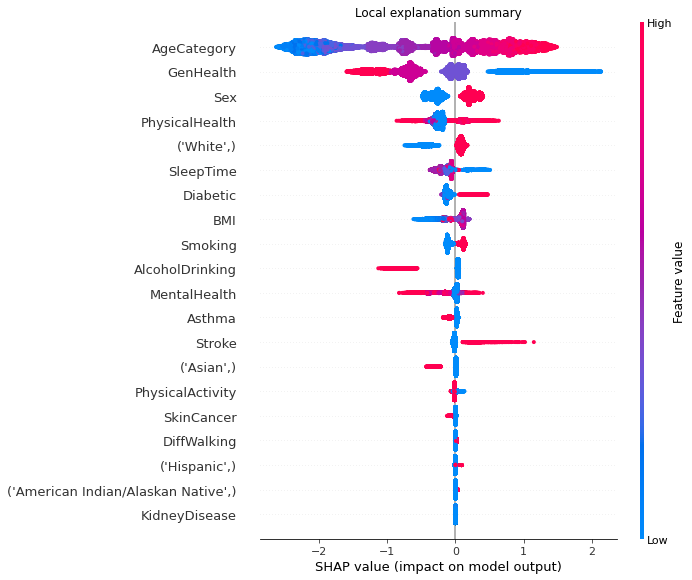

In [44]:
# SHAP
explainer = shap.Explainer(model_BorderlineSM, x_train_BorderlineSM, feature_names=features)
shap_values = explainer(x_test, check_additivity=False)

plt.title('Global feature importance')
shap.summary_plot(shap_values, plot_type="bar")


plt.title('Local explanation summary')
shap.summary_plot(shap_values)

## SVMSMOTE

In [45]:
model_SVMSMOTE = xgb.XGBClassifier()
model_SVMSMOTE.fit(x_train_SVMSMOTE, y_train_SVMSMOTE)

XGBClassifier()

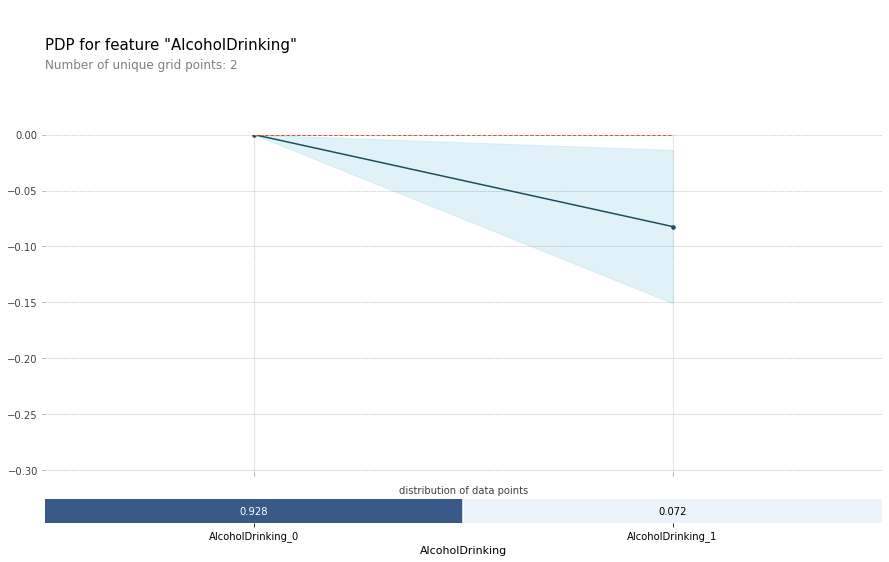

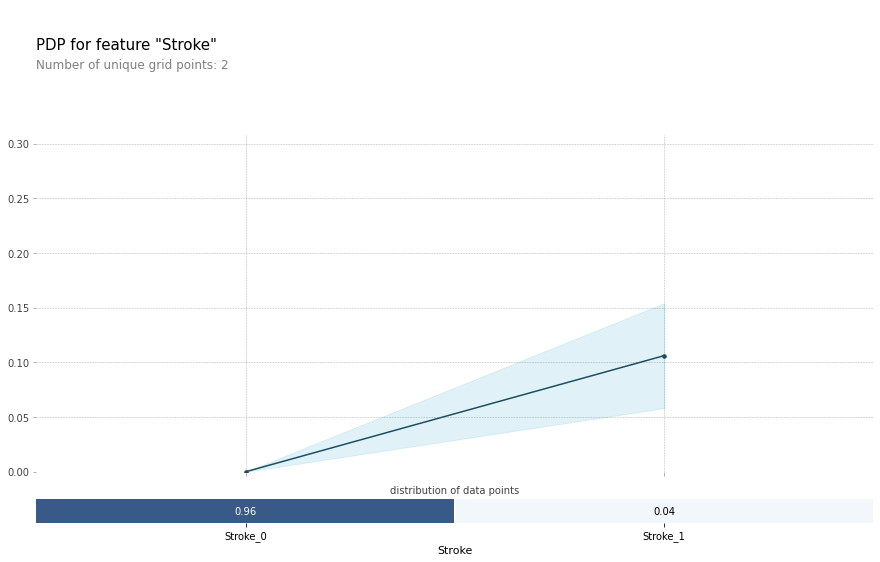

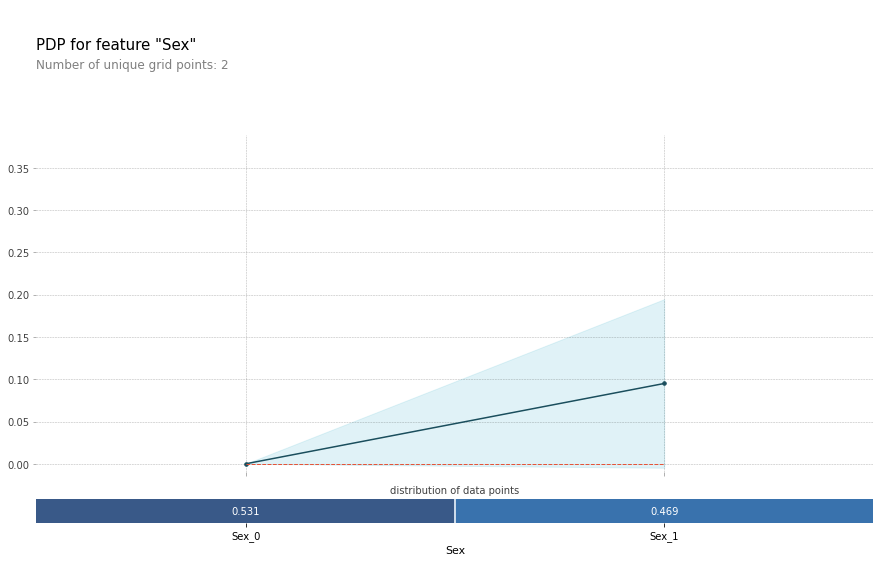

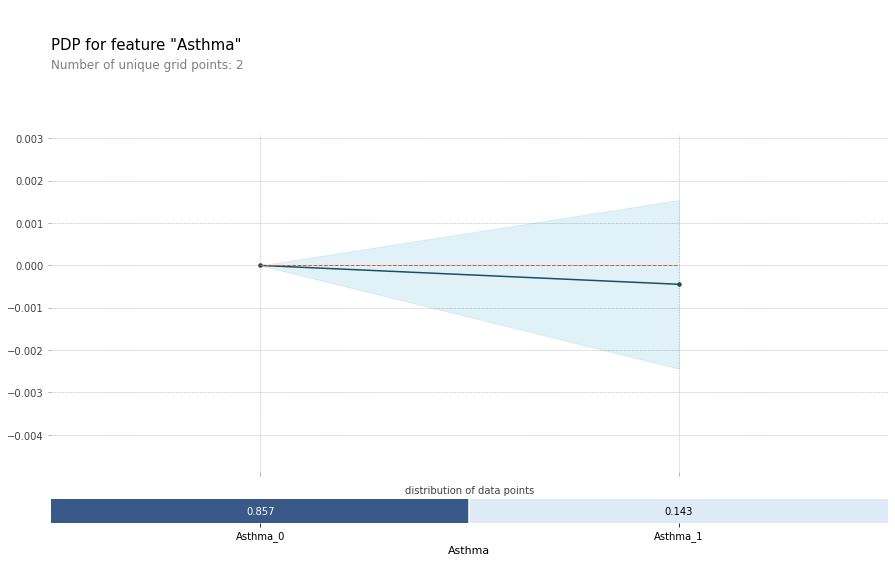

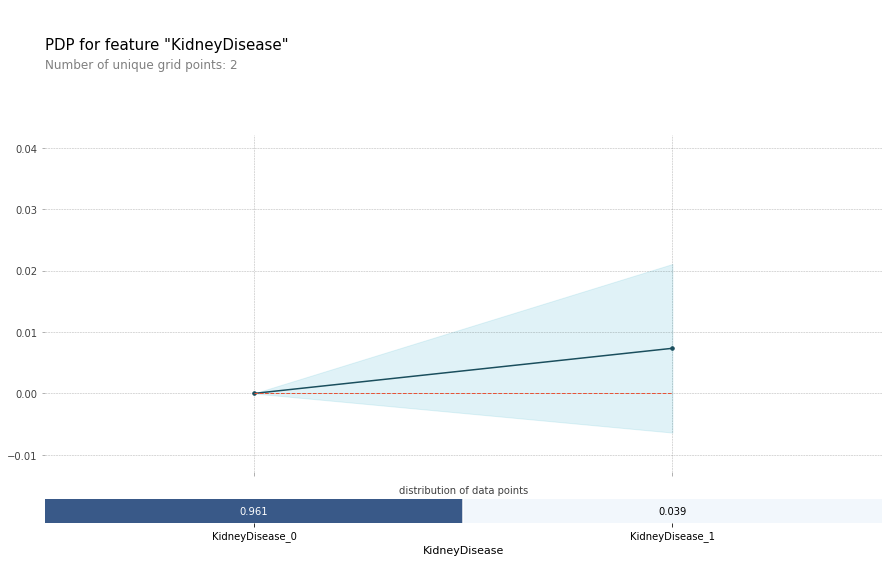

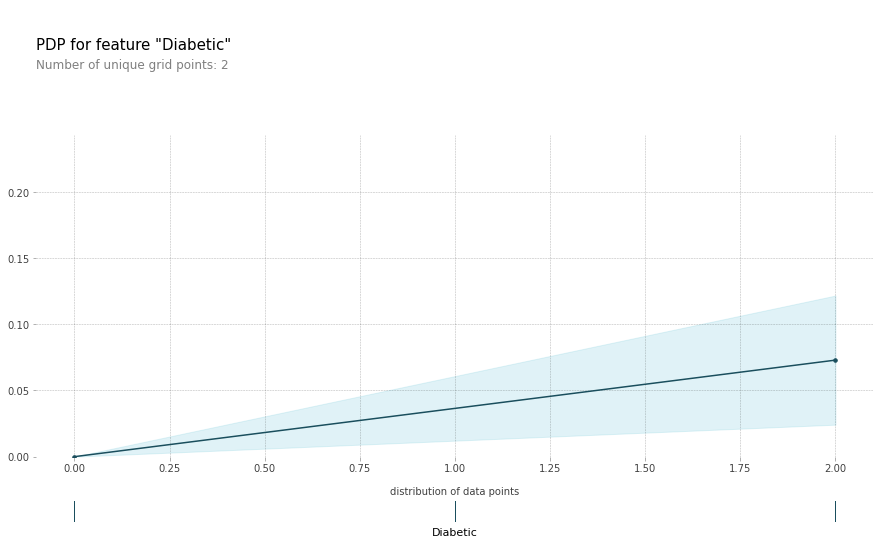

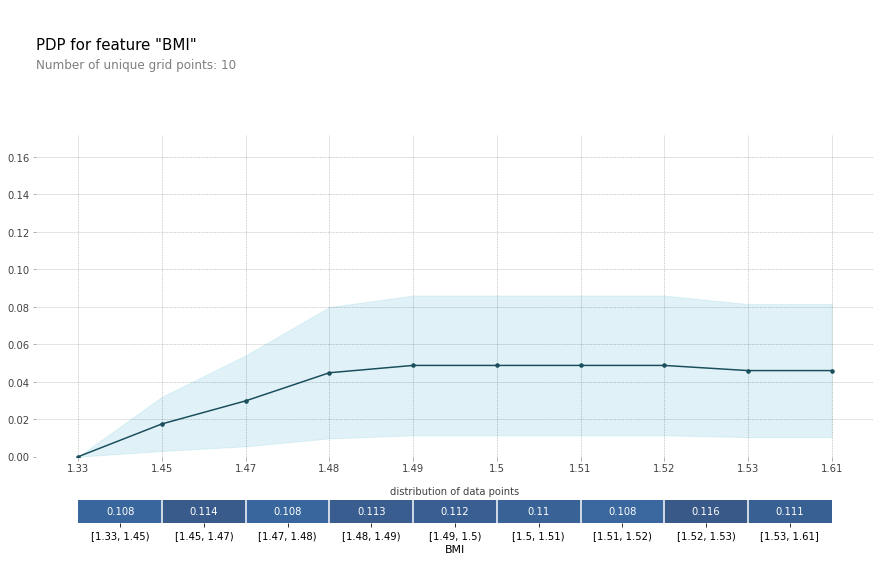

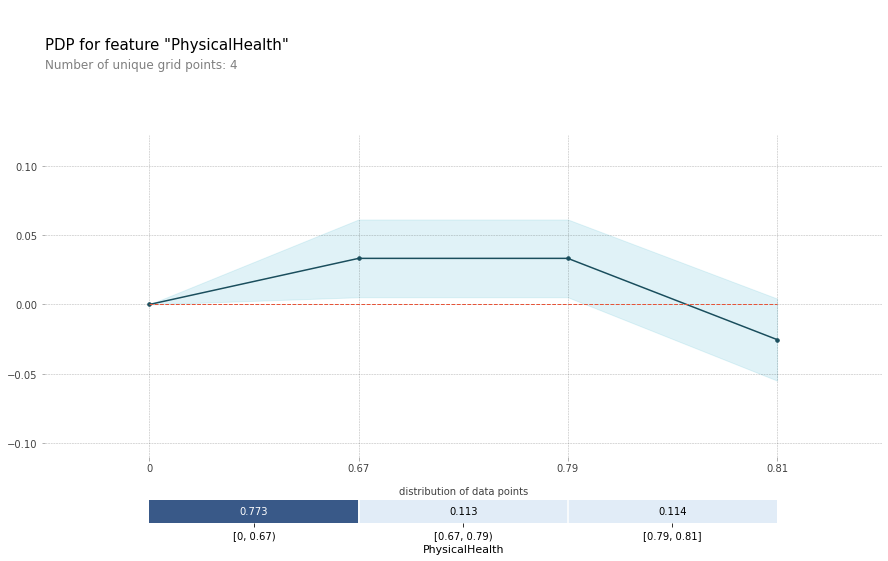

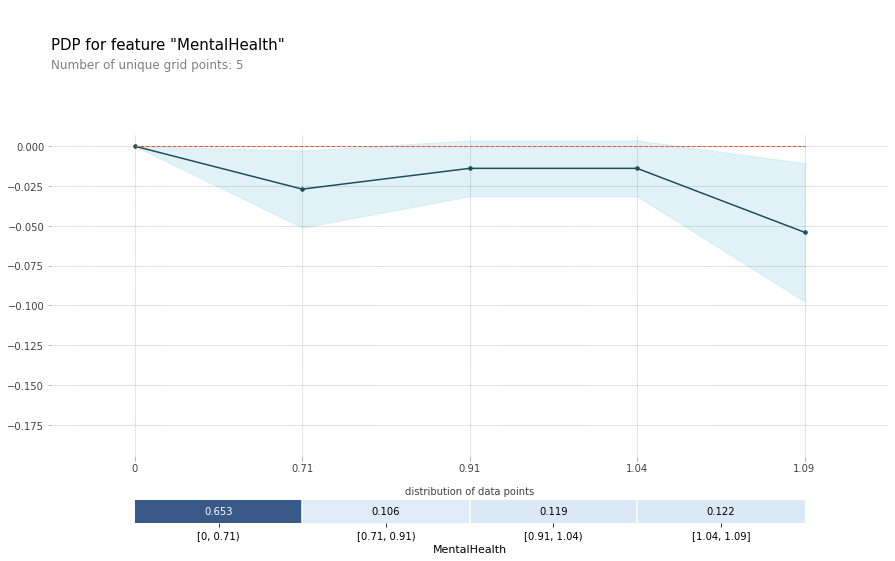

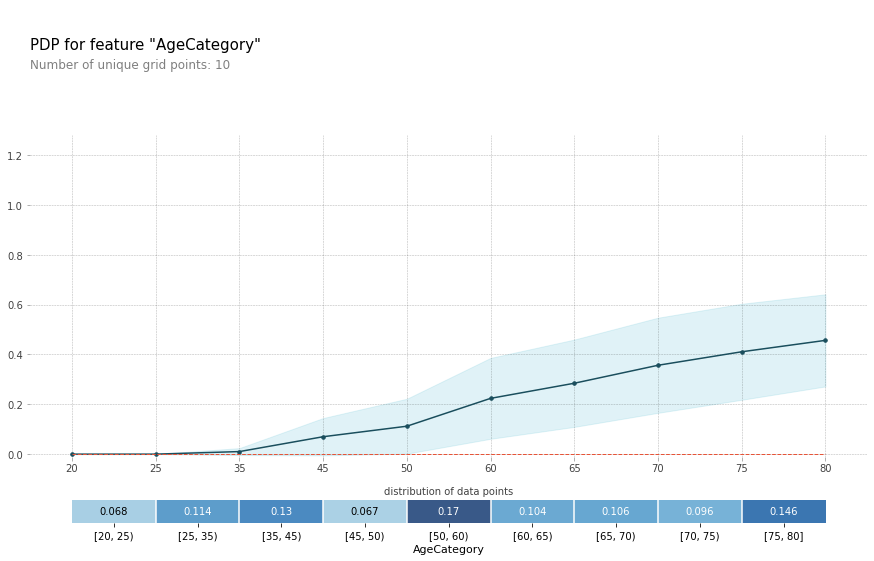

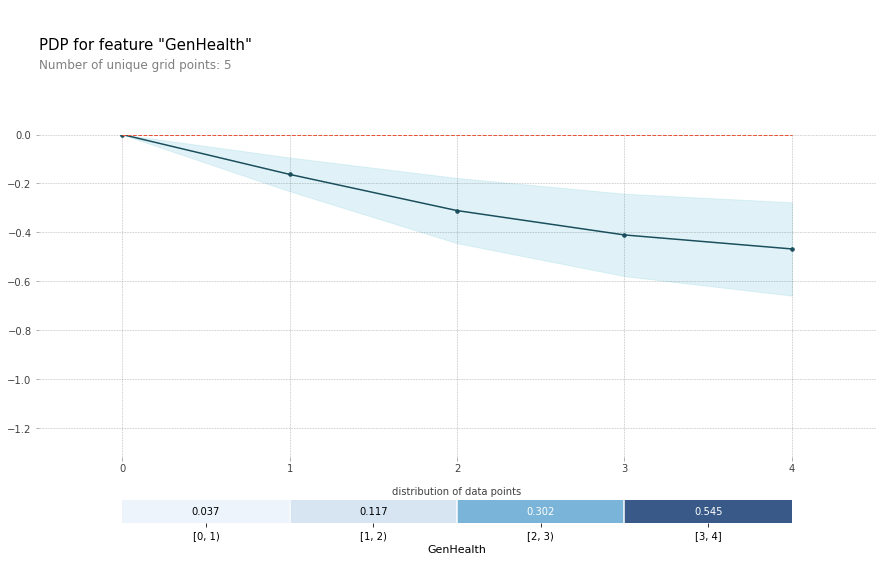

In [46]:
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_SVMSMOTE, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i], plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_SVMSMOTE, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], plot_pts_dist=True,  x_quantile=True)

In [47]:
# ICE
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_SVMSMOTE, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i],frac_to_plot=1000, plot_lines=True, plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_SVMSMOTE, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], frac_to_plot=1000, plot_lines=True, plot_pts_dist=True,  x_quantile=True)

Output hidden; open in https://colab.research.google.com to view.

 99%|===================| 59646/60331 [01:13<00:00]       

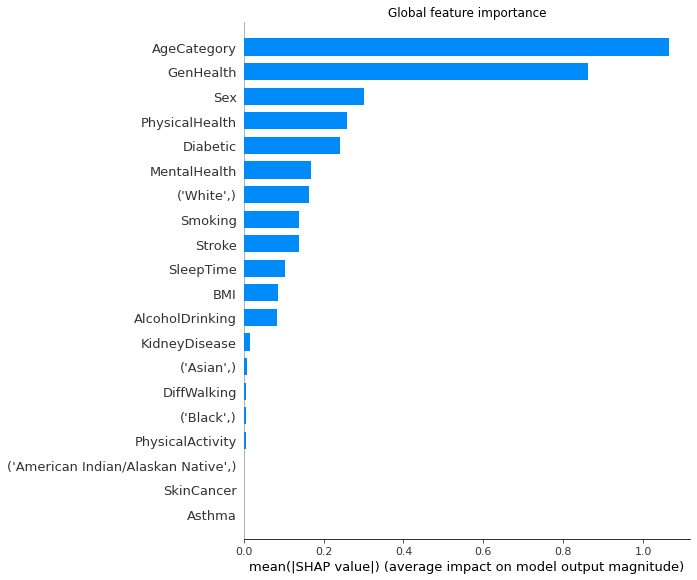

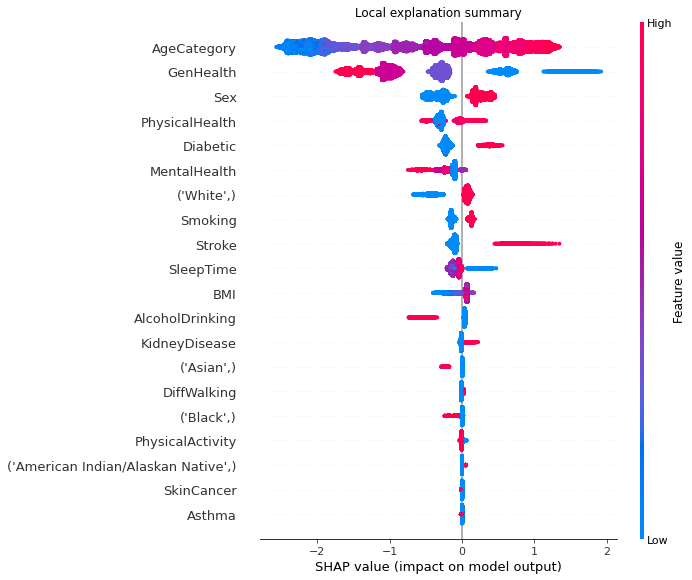

In [48]:
# SHAP
explainer = shap.Explainer(model_SVMSMOTE, x_train_SVMSMOTE, feature_names=features)
shap_values = explainer(x_test, check_additivity=False)

plt.title('Global feature importance')
shap.summary_plot(shap_values, plot_type="bar")


plt.title('Local explanation summary')
shap.summary_plot(shap_values)

## ADASYN

In [49]:
model_ADASYN = xgb.XGBClassifier()
model_ADASYN.fit(x_train_ADASYN, y_train_ADASYN)

XGBClassifier()

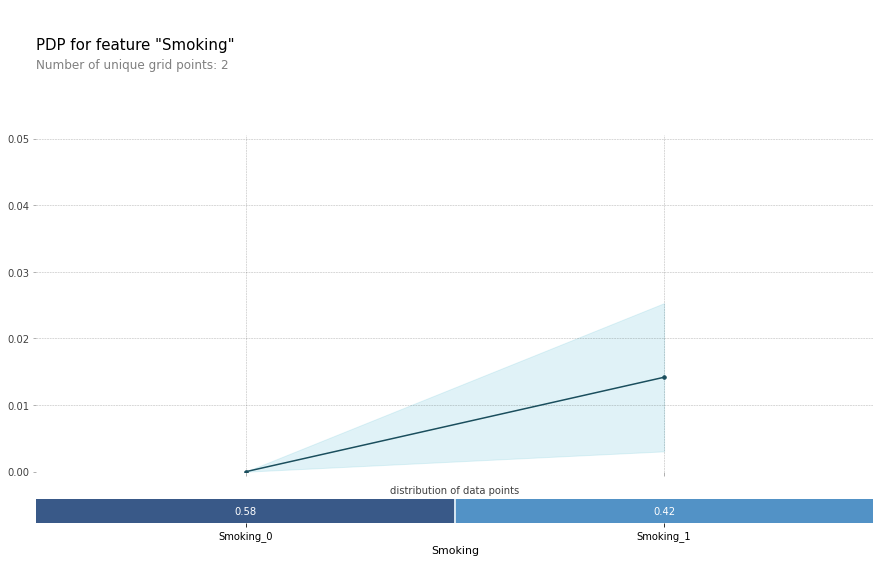

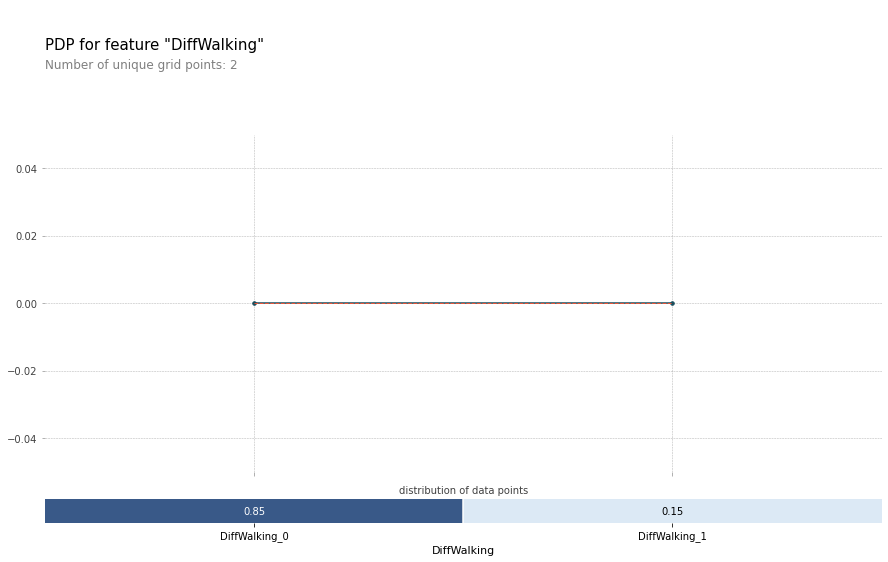

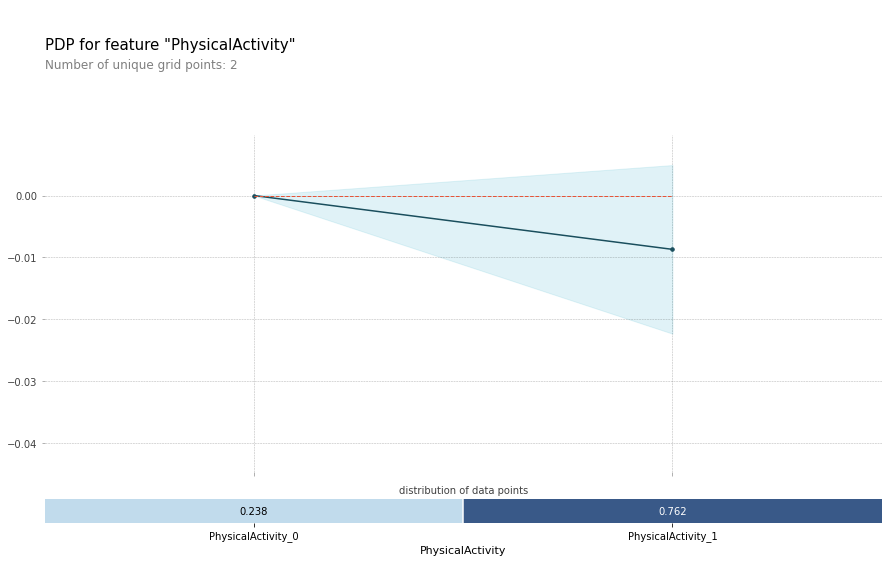

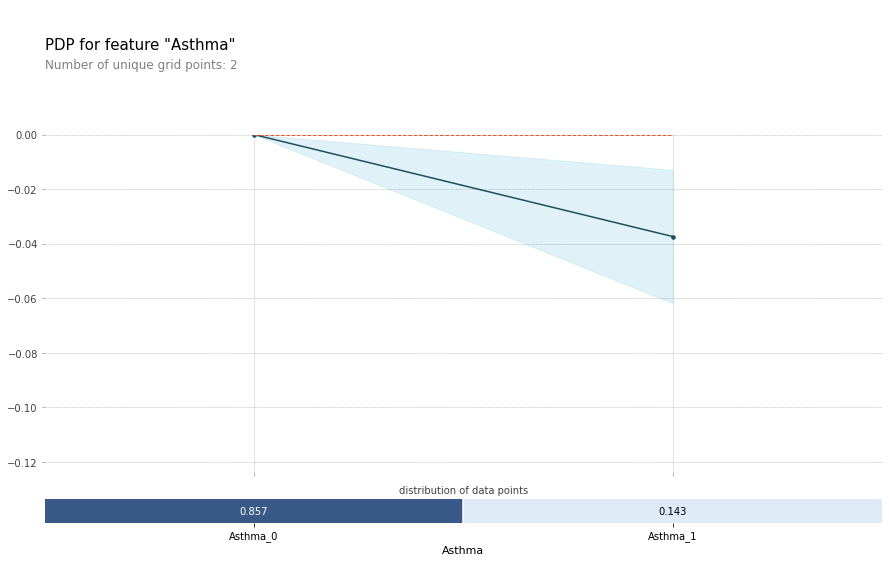

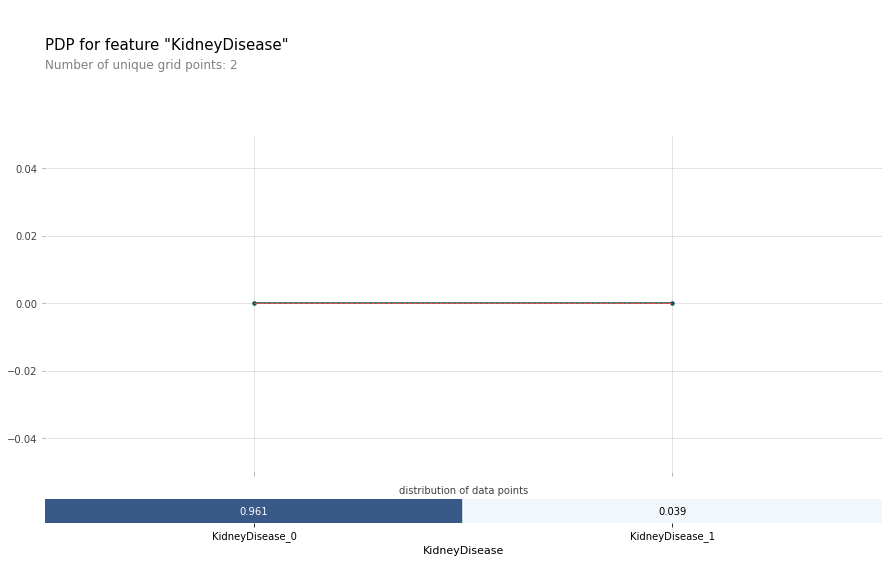

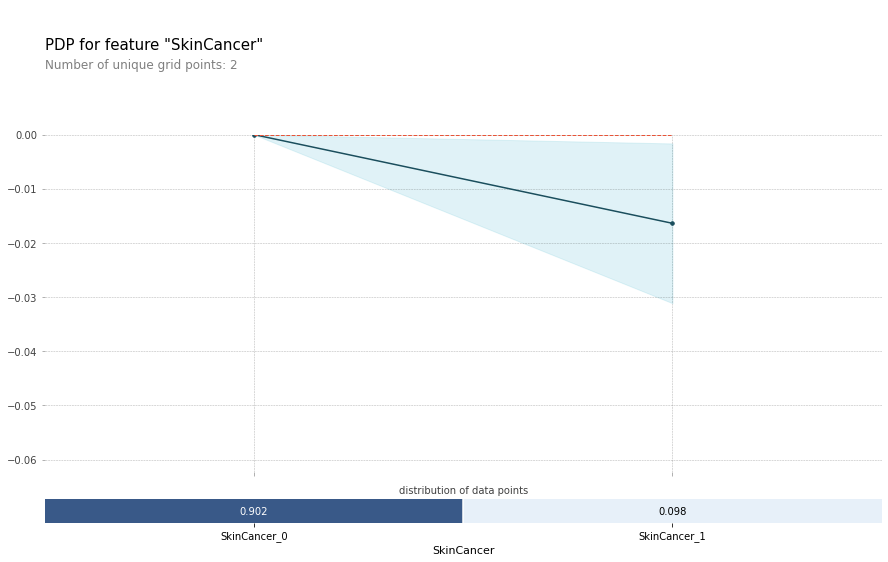

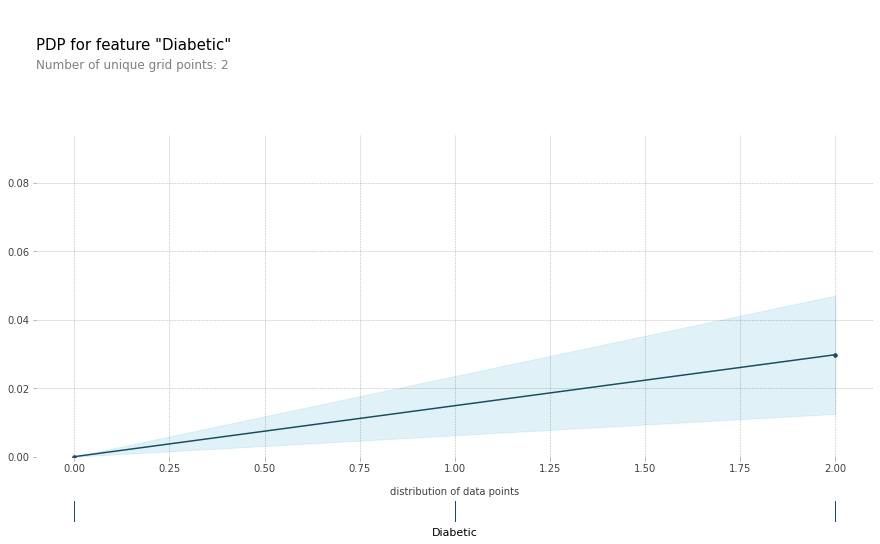

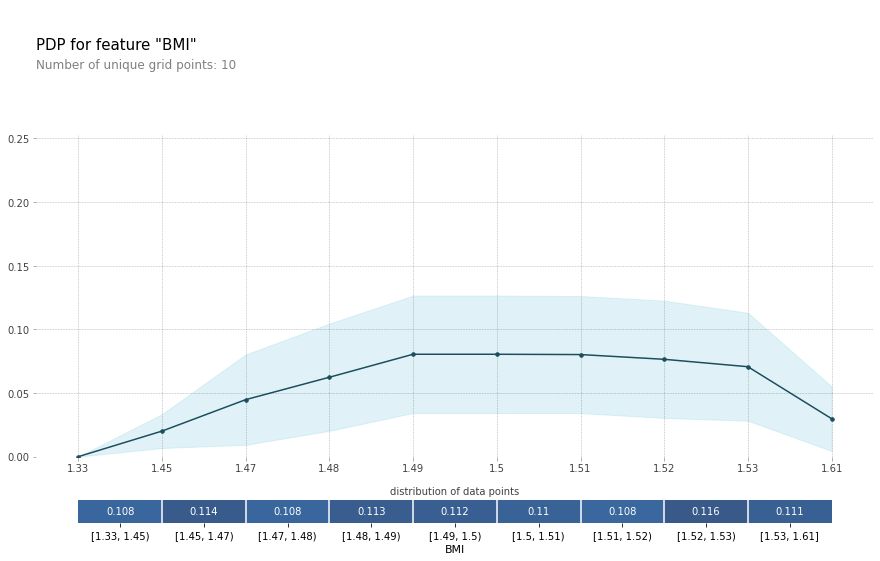

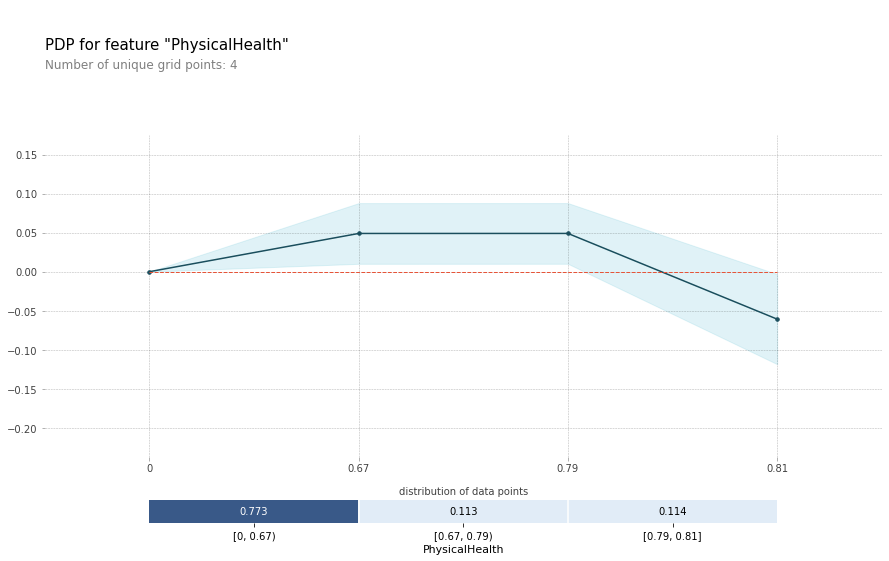

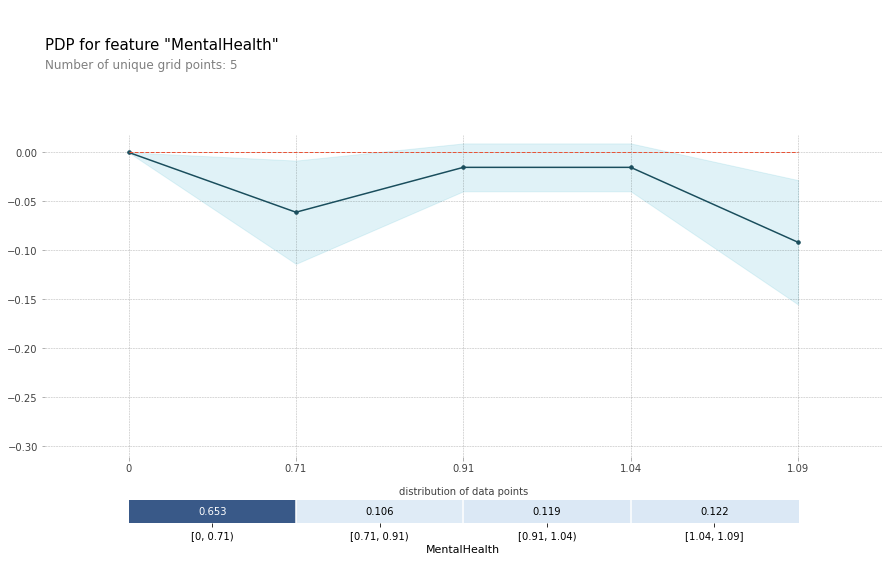

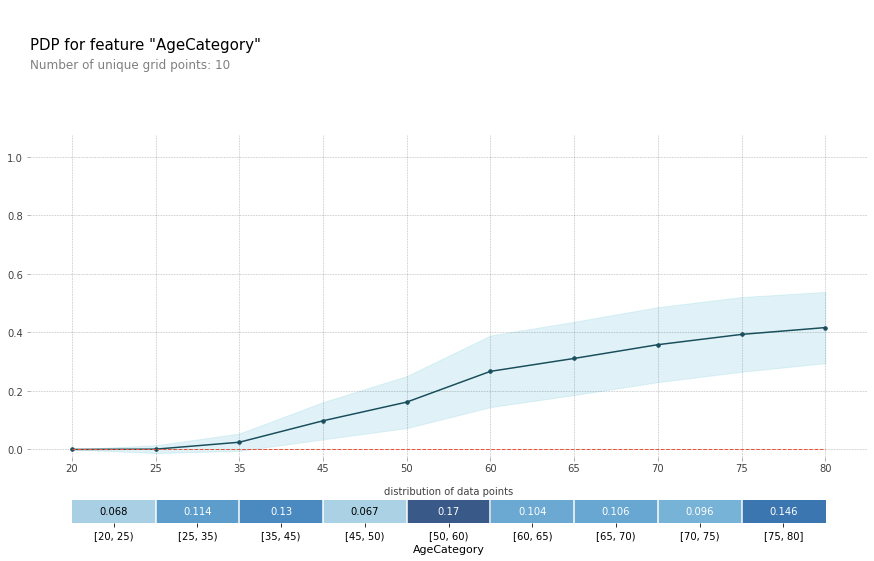

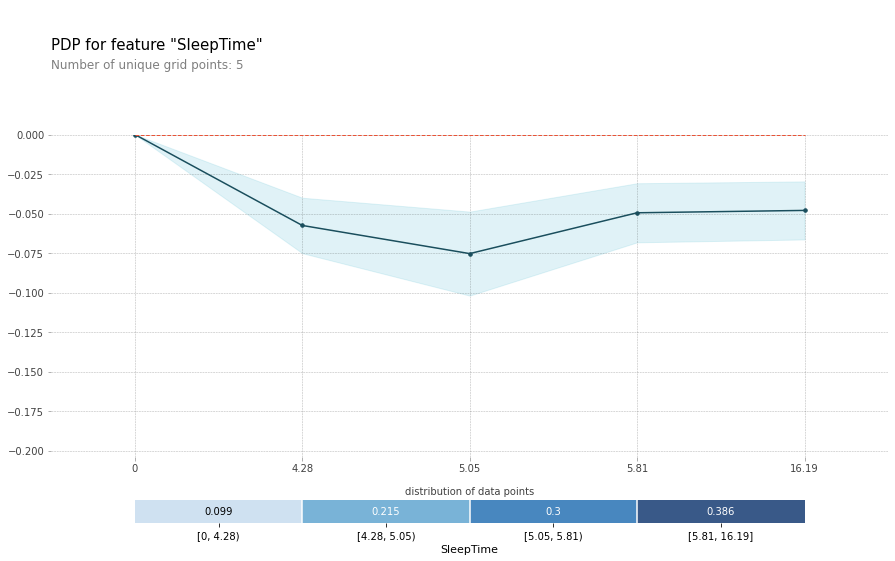

In [50]:
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_ADASYN, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i], plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_ADASYN, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], plot_pts_dist=True,  x_quantile=True)

In [51]:
# ICE
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_ADASYN, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i],frac_to_plot=1000, plot_lines=True, plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_ADASYN, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], frac_to_plot=1000, plot_lines=True, plot_pts_dist=True,  x_quantile=True)

Output hidden; open in https://colab.research.google.com to view.

 99%|===================| 59634/60331 [01:10<00:00]       

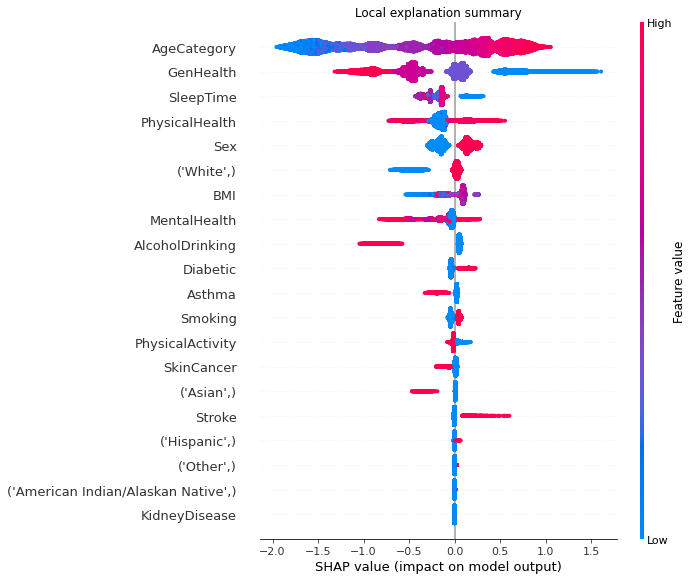

In [52]:
# SHAP
explainer = shap.Explainer(model_ADASYN, x_train_ADASYN, feature_names=features)
shap_values = explainer(x_test, check_additivity=False)

plt.title('Global feature importance')
shap.summary_plot(shap_values, plot_type="bar")


plt.title('Local explanation summary')
shap.summary_plot(shap_values)

## SMOTEENN

In [53]:
model_SMOTEENN = xgb.XGBClassifier()
model_SMOTEENN.fit(x_train_SMOTEENN, y_train_SMOTEENN)

XGBClassifier()

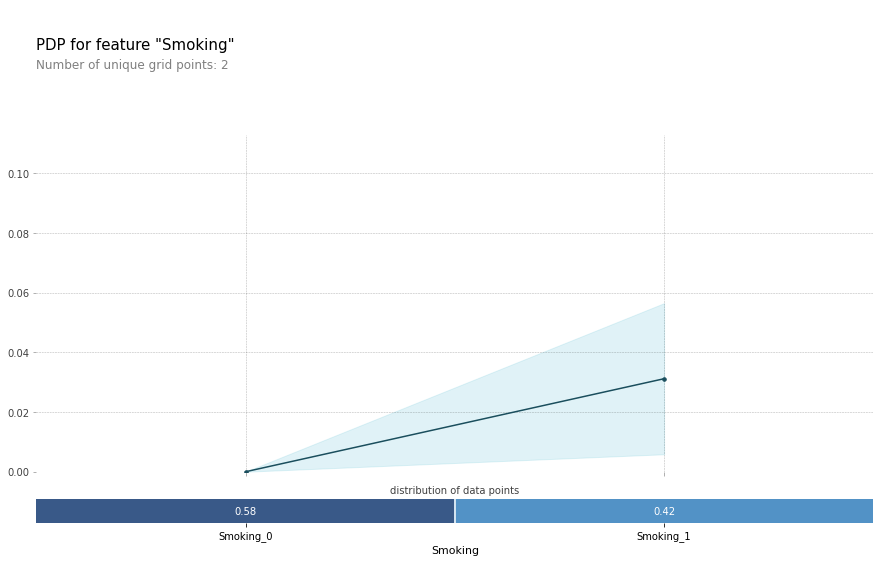

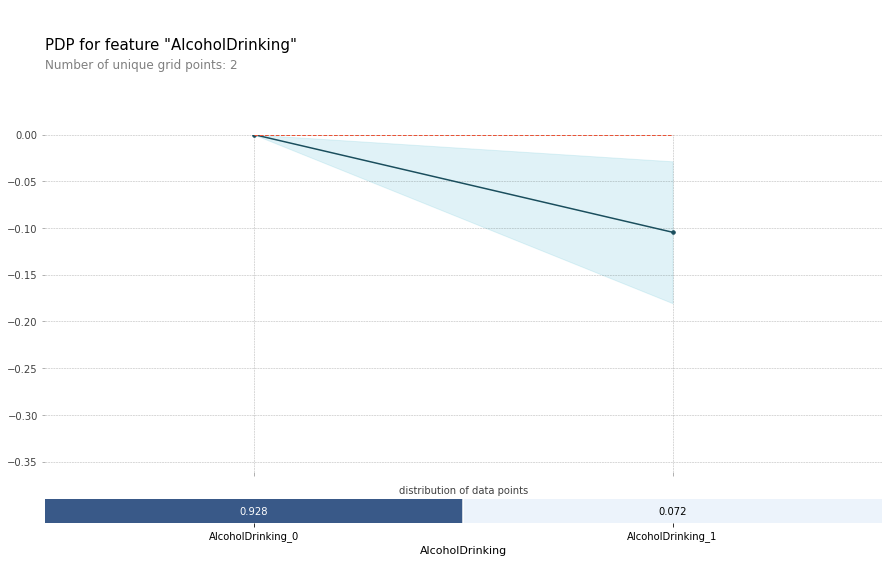

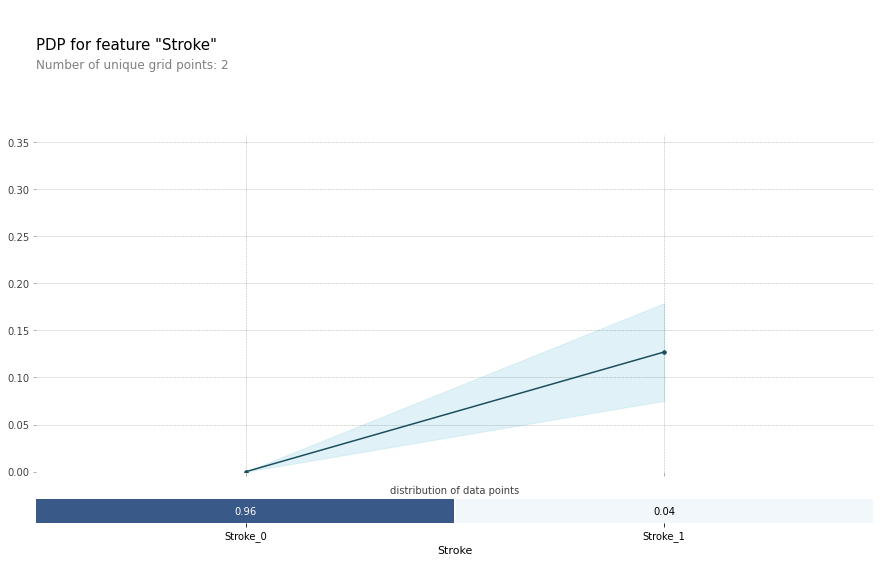

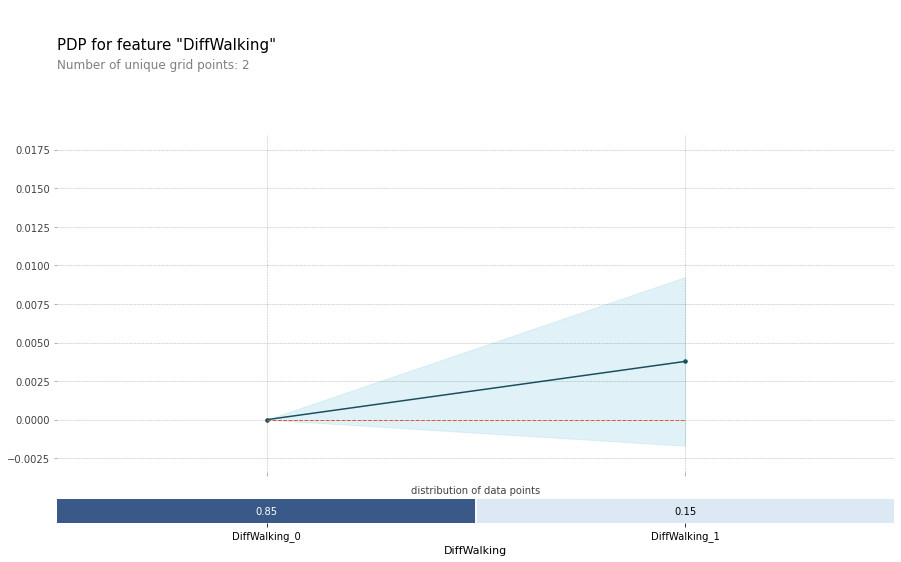

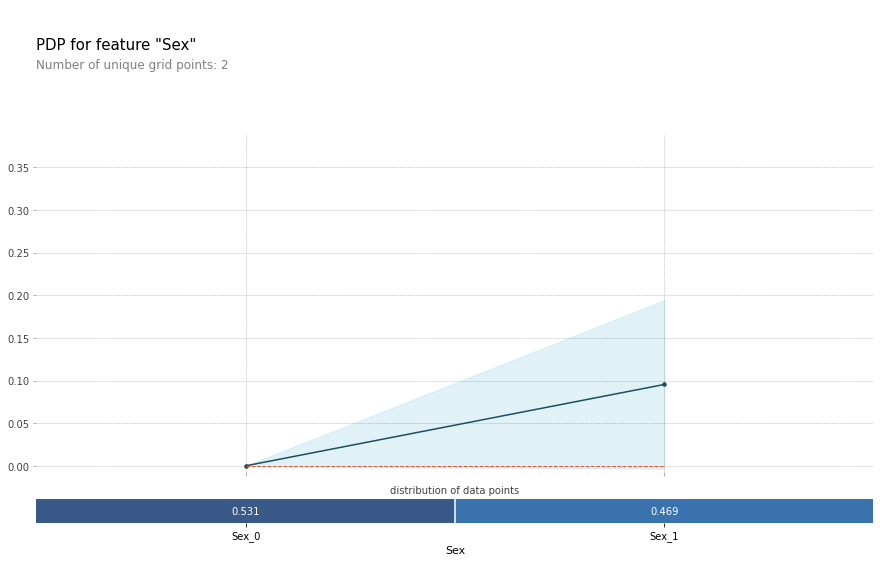

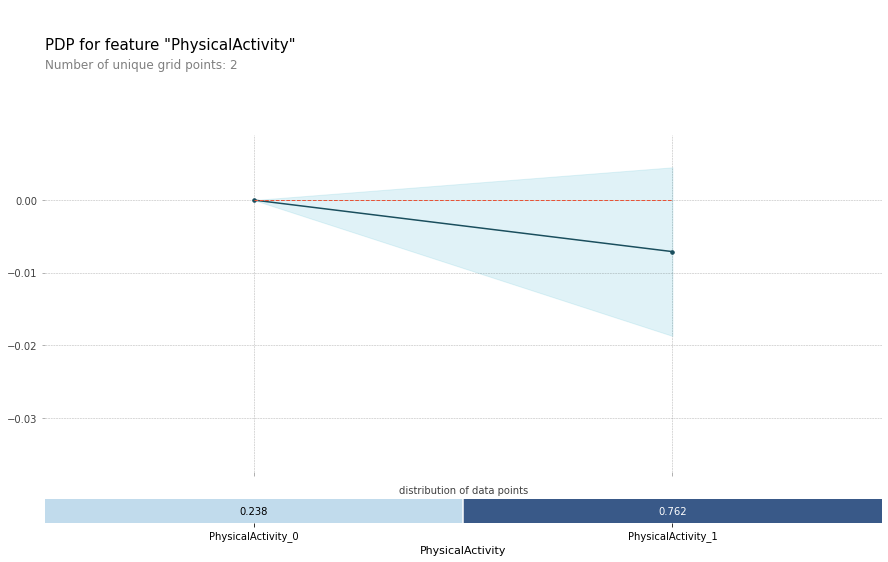

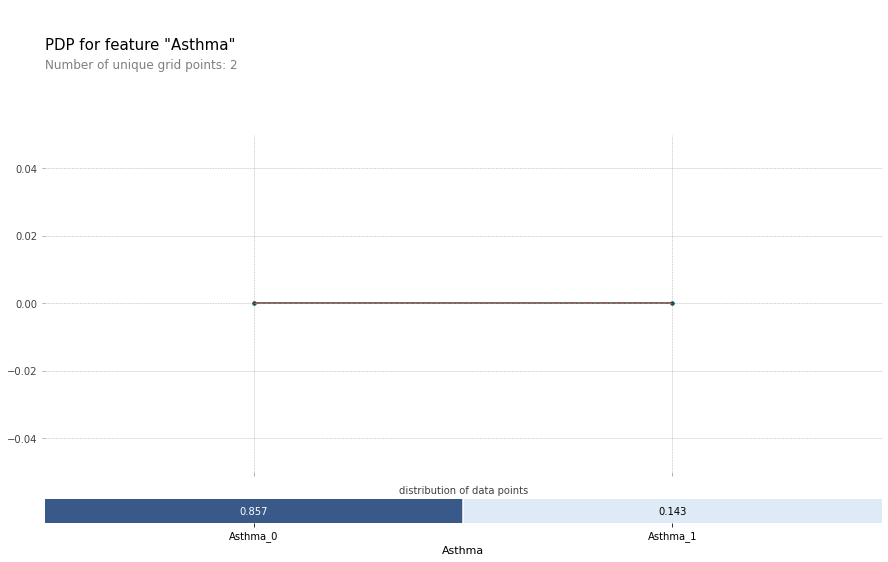

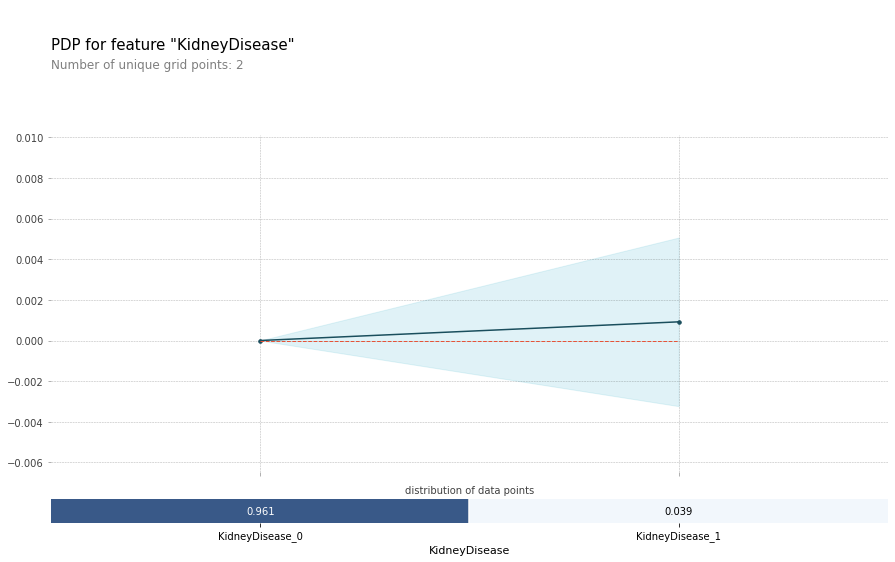

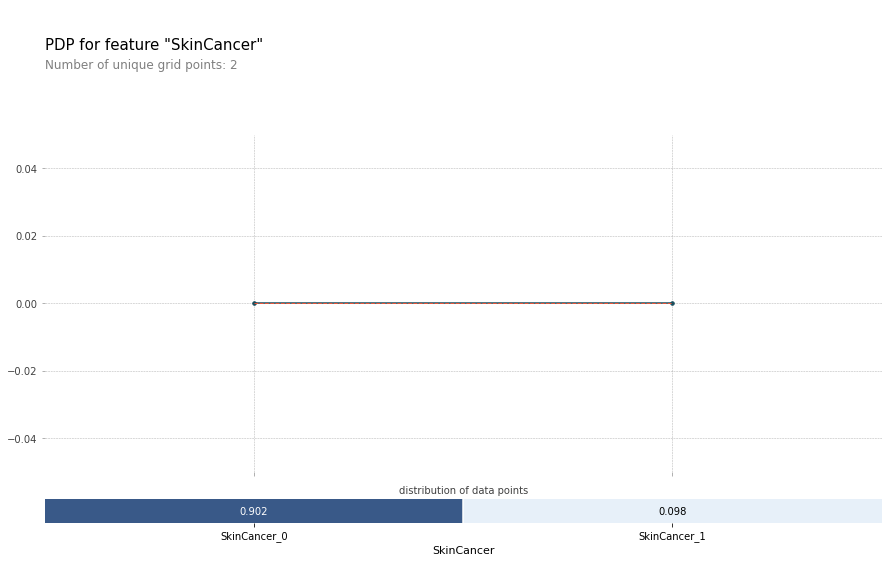

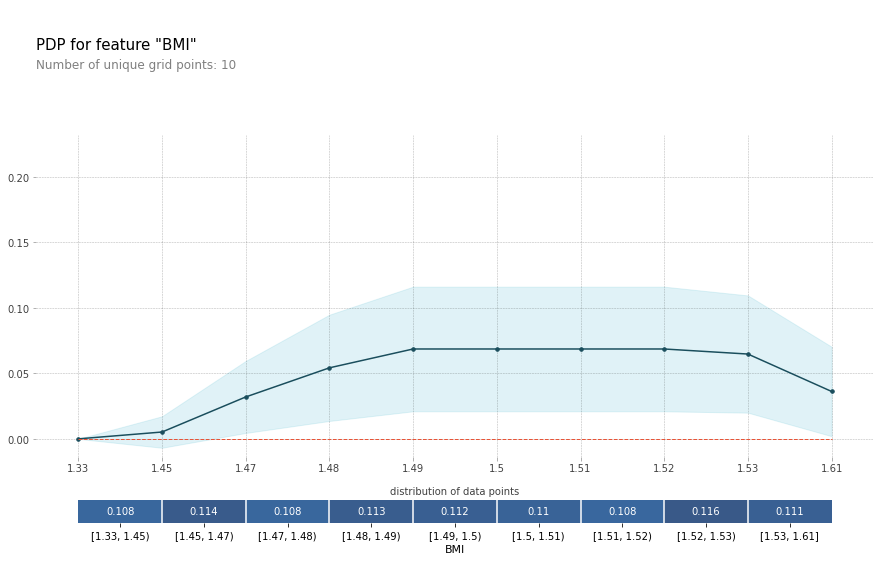

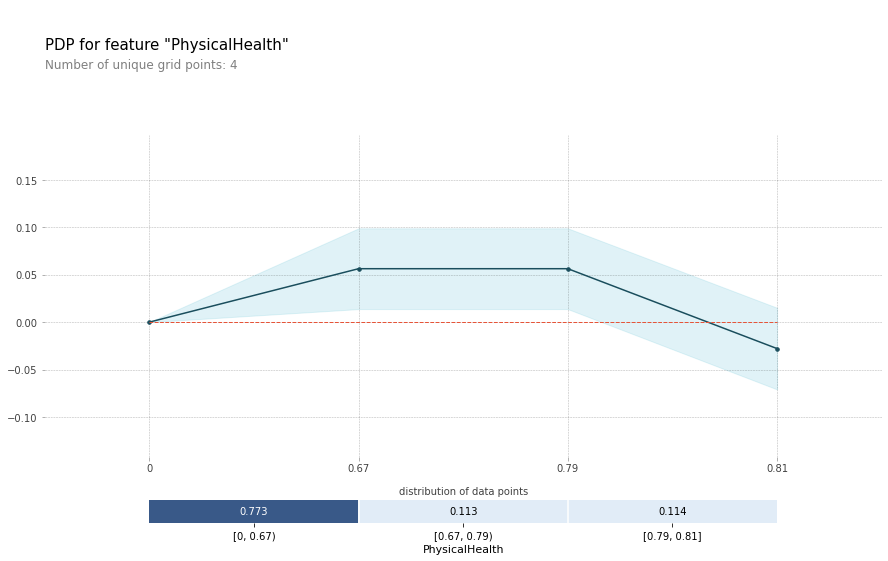

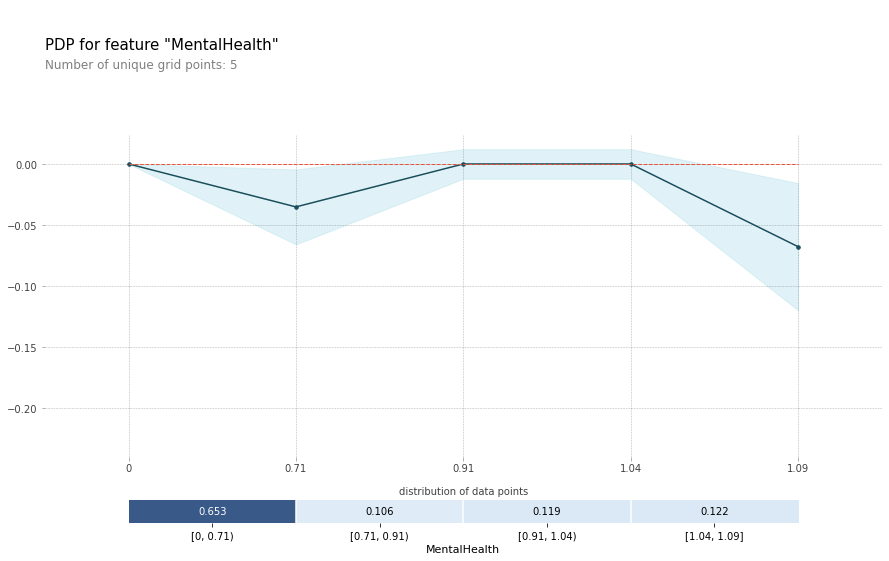

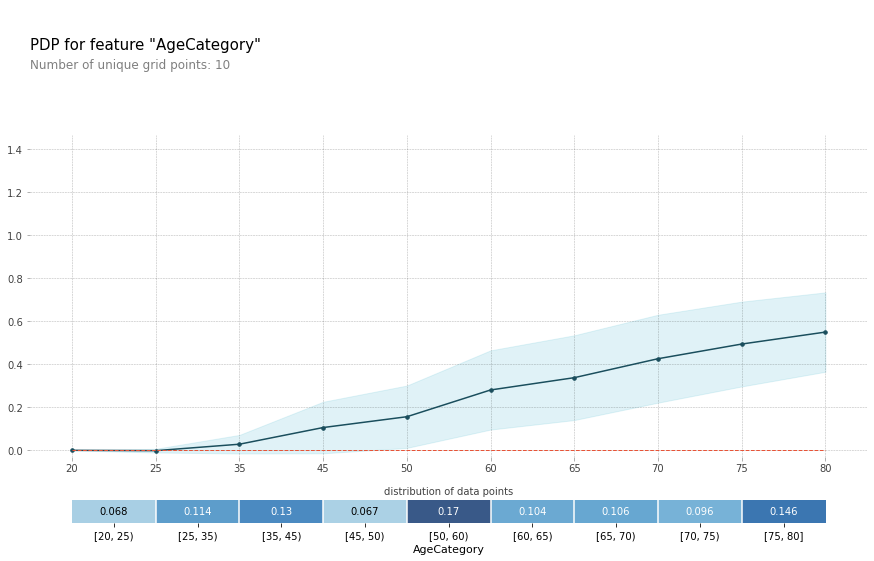

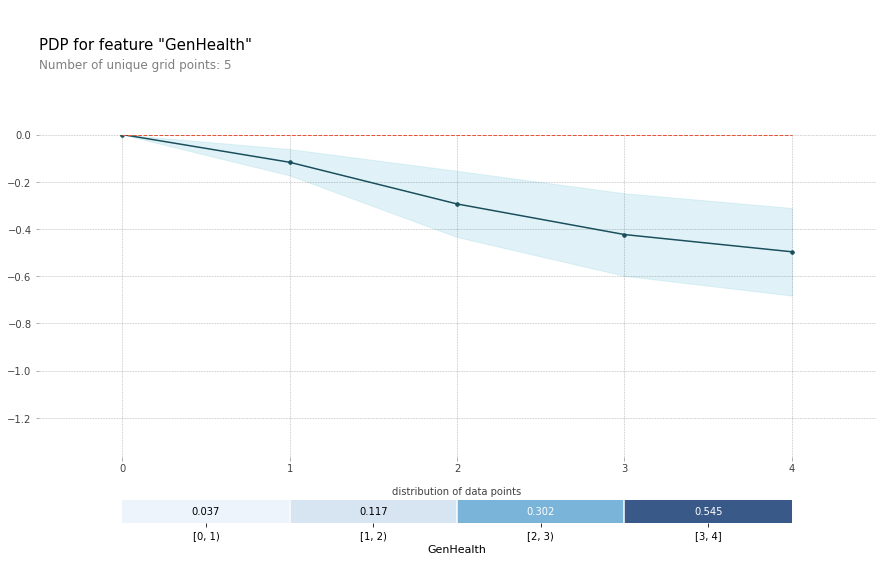

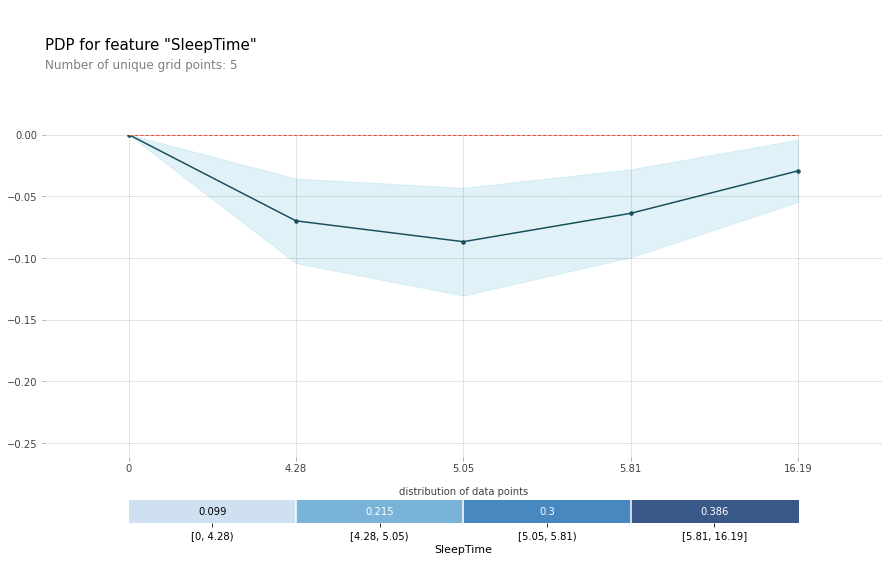

In [54]:
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_SMOTEENN, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i], plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_SMOTEENN, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], plot_pts_dist=True,  x_quantile=True)

In [55]:
# ICE
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_SMOTEENN, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i],frac_to_plot=1000, plot_lines=True, plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_SMOTEENN, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], frac_to_plot=1000, plot_lines=True, plot_pts_dist=True,  x_quantile=True)

Output hidden; open in https://colab.research.google.com to view.

 99%|===================| 59702/60331 [01:12<00:00]       

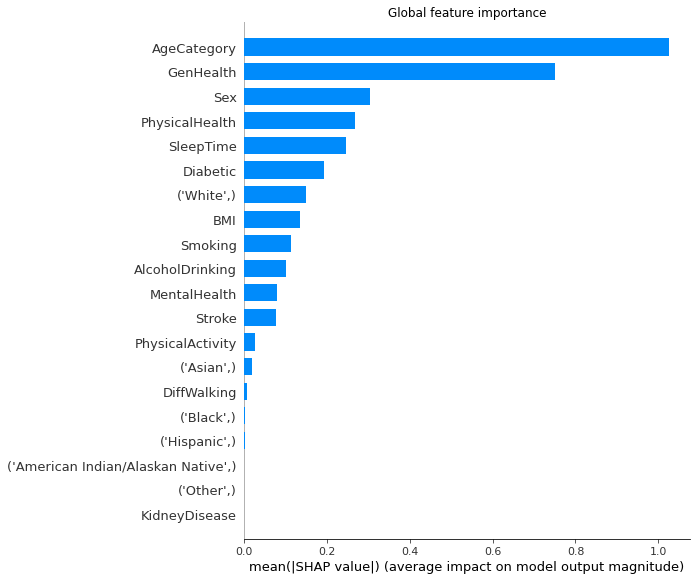

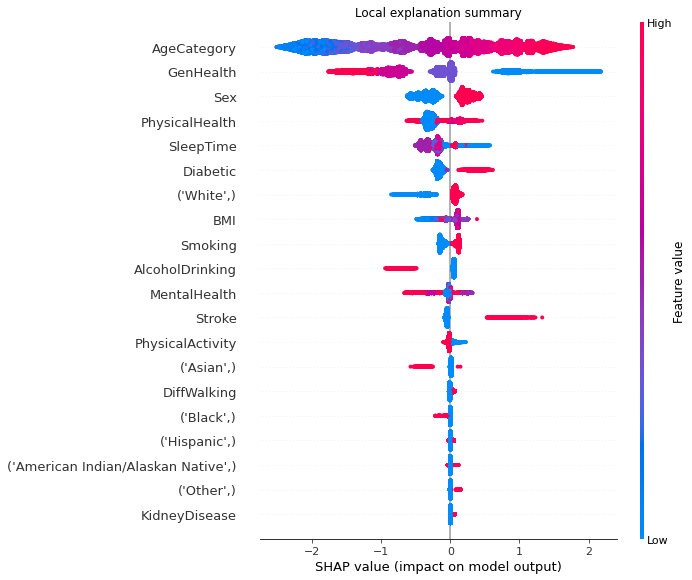

In [56]:
# SHAP
explainer = shap.Explainer(model_SMOTEENN, x_train_SMOTEENN, feature_names=features)
shap_values = explainer(x_test, check_additivity=False)

plt.title('Global feature importance')
shap.summary_plot(shap_values, plot_type="bar")


plt.title('Local explanation summary')
shap.summary_plot(shap_values)